Das script is zum abgeben!!!!!

**Author**: Dalia Konieczny and Youssef Elmaraghy

**Short description**:
This script performs a bayesian optimization on the baseline 1DCNN model with a k-Fold crossvalidation

**Long description of the script**:
In the beginning of the script the dataset is split into two parts by labels, so one dataset contains the first six labels and the other dataset contains the remaining labels. This makes it possible to perform an optimization on a model trained on a smaller dataset.

1. Model definition
This part contains the definition of the 1-D CNN model and LSTM model, so that the model architecture to be optimized could be chosen. **However**, the optimization of LSTM doesn’t work yet and therefore it’s the option is switched off in part three of the script.
The same functions as for constructing the baseline models are used, but some are slightly adjusted.  The class for each architecture gets the parameters passed, that are to be optimized. The evaluation function was changed, so that it returns the accuracy score for the acquisition()-function.

2. Define k-fold cross validation
In this part the cross validation function is defined which is responsible for training the model in a k-fold approach.  

3. Optimizing
This part performs the optimizing. First, the model to be trained can be chosen by setting the variable “lstm_flag”. Since LSTM optimization doesn’t work yet it is set to 0. In the next step the acquisition()-function is defined which is then later called multiple times by the optimize()-function. The acquisition()-function calls the cross-validation function and returns the mean accuracy of the five trainings for each call.
The last cell the optimize function is called which gets the parameters that are to be optimized including the ranges for each parameter, the acquisition function and the objective passed.
After running 20 trails the script will output the best parameter combination.


In [1]:
# Connect to the Github Repository
! git clone https://github.com/ZhuYuqicheng/Deep-Learning-Lab-Time-Series.git
# set up the right directory path
%cd /content/Deep-Learning-Lab-Time-Series

fatal: destination path 'Deep-Learning-Lab-Time-Series' already exists and is not an empty directory.
/content/Deep-Learning-Lab-Time-Series


In [2]:
# IMPORTANT: For this script to run this command has to be run once
!pip install ax-platform

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# import useful functions
from DataGeneration import GenerateHARData, GenerateHAPTData
from utils import ShowSegmentation, ShowPosturalTransitions, PlotTimeSeries, PlotLabelDist, FeatureSelection

In [4]:
import seaborn as sns
import pandas as pd
from ax.plot.contour import plot_contour
from ax.plot.trace import optimization_trace_single_method
from ax.service.managed_loop import optimize
from ax.utils.notebook.plotting import render
from ax.utils.tutorials.cnn_utils import train, evaluate
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, random_split, DataLoader
from sklearn.metrics import accuracy_score


In [5]:
# load the pre-processed time series data
# if you want to load HAPT dataset, just change the class to GenerateHAPTData
X, y = GenerateHAPTData().run()

In [6]:
#Splitting of the dataset so a trained model on a smaller dataset can be optimized
df = pd.DataFrame(y, columns = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING','STAND_TO_SIT','SIT_TO_STAND','SIT_TO_LIE','LIE_TO_SIT','STAND_TO_LIE','LIE_TO_STAND' ])
transition_indicies=df[(df['STAND_TO_SIT']==1.0)|(df['SIT_TO_STAND']==1.0)|(df['SIT_TO_LIE']==1.0)|(df['LIE_TO_SIT']==1.0)|(df['STAND_TO_LIE']==1.0)|(df['LIE_TO_STAND']==1.0)].index.to_numpy()

#Create transition data 
X_transition=np.take(X,transition_indicies,axis=0)
y_transition=np.take(y,transition_indicies,axis=0)

#create position data
position_indicies=df[(df['WALKING']==1.0)|(df['WALKING_UPSTAIRS']==1.0)|(df['WALKING_DOWNSTAIRS']==1.0)|(df['SITTING']==1.0)|(df['STANDING']==1.0)|(df['LAYING']==1.0)].index.to_numpy()
X_position=np.take(X,position_indicies,axis=0)
y_position=np.take(y,position_indicies,axis=0)

## 1.Model definition

In [7]:
class CSVDataset(Dataset):
    # load the dataset
    def __init__(self, X, y):
        # adapt the data dimension to pytorch implementation
        XT = torch.from_numpy(X)
        self.X = XT.transpose(1,2).float()
        self.y = torch.from_numpy(y).float()
    # number of rows in the dataset
    def __len__(self):
        return len(self.X)
    # get a row at an index
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]
    # split the train and test data
    def get_splits(self, train_rate):
        n_data = len(self.X)
        train_size = int(n_data*train_rate)
        test_size = n_data - train_size
        return random_split(self, [train_size, test_size])

class OneDCNN(nn.Module):
    """
    Implementation of 1D CNN model.
    This Class defines the details of your 1D CNN model.
    Fel free to change any hyperparameters of the model e.g. kernel_size, number of layers, etc.
    ---
    Please change the hyperparameters of model architecture and run some experiment by yourself. :)
    """
    def __init__(self, params, n_timesteps, n_features, n_outputs):
        super(OneDCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(n_features, params.get("out_channels",64), kernel_size=params.get("k_size",7)),
            nn.ReLU(),
            nn.Dropout(params.get("d_out",0.5)),
            nn.MaxPool1d(2))
        self.layer2 = nn.Flatten()
        #we need to find out dimension for layer 3
        m1=self.layer1
        input = torch.randn(32, 6, 128)
        output1 = m1(input)
        m2=self.layer2
        output2 = m2(output1)
        self.layer3 = nn.Sequential(
            nn.Linear(output2.shape[1],100),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Linear(100,n_outputs),
            nn.Softmax(dim=1))
       
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        return out

class LSTM(nn.Module):
    
    def __init__(self,params,inputNode,hiddenNode,outputNode,layer_num):
        super(LSTM,self).__init__()
        self.hidden_dim = params.get("hiddenNode",hiddenNode)
        self.output_dim = outputNode
        self.lstm = nn.LSTM(inputNode,params.get("hiddenNode",hiddenNode),params.get("layer_num",layer_num),params.get("dropout",0.25),batch_first=True)
        self.fc = nn.Linear(params.get("hiddenNode",hiddenNode),outputNode)
        self.bn = nn.BatchNorm1d(6)
        
    def forward(self,inputs):
        x = self.bn(inputs)
        print(x.shape)
        lstm_out,(hn,cn) = self.lstm(x)
        out = self.fc(lstm_out[:,-1,:])
        return out

def train_model(train_dl, params, model, epoch):
    # define loss function
    criterion = nn.CrossEntropyLoss()
    # define optimizer (you can try to change optimizer),
    print("Learn rate:",params.get("lr",0.001))
    # pass the parameter that needs to be optimzed to Adam
    optimizer = torch.optim.Adam(model.parameters(),params.get("lr",0.001))
    # enumerate epochs
    accuracy = list()
    for epoch in range(epoch):
        predictions, actuals = list(), list()
        # enumerate mini batches
        for i, (inputs, targets) in enumerate(train_dl):
            #inputs = inputs.to(dtype=dtype, device=device)
            #targets = targets.to(device=device)
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            yhat = model(inputs)
            # calculate loss
            loss = criterion(yhat, targets)
            # credit assignment
            loss.backward()
            # update model weights
            optimizer.step()
            # record result for mini batch
            predictions.append(np.argmax(yhat.detach().numpy(), axis=1))
            actuals.append(np.argmax(targets.numpy(), axis=1))
        predictions, actuals = np.concatenate(predictions), np.concatenate(actuals)
        acc = accuracy_score(actuals, predictions)
        accuracy.append(acc)
        print(f"Epoch: {epoch+1}; Accuracy: {acc}")

    # learning process visualization
    plt.title('Training Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.grid(True)
    plt.autoscale(axis='x', tight=True)
    plt.plot(accuracy)
    plt.show()

def evaluate_test(net: nn.Module, data_loader: DataLoader, dtype: torch.dtype, device: torch.device
) -> float:
    """
    Compute classification accuracy on provided dataset.

    Args:
        net: trained model
        data_loader: DataLoader containing the evaluation set
        dtype: torch dtype
        device: torch device
    Returns:
        float: classification accuracy
    """
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
          predictions, actuals = list(), list()
          for i, (inputs, targets) in enumerate(data_loader):
              # move data to proper dtype and device
              inputs = inputs.to(dtype=dtype, device=device)
              targets = targets.to(device=device)
              # evaluate the model on the test set
              yhat = net(inputs)
              # retrieve numpy array
              predictions.append(np.argmax(yhat.detach().numpy(), axis=1))
              actuals.append(np.argmax(targets.numpy(), axis=1))
          predictions, actuals = np.concatenate(predictions), np.concatenate(actuals)
          # calculate accuracy
    return accuracy_score(actuals, predictions)

## 2. Define k-fold cross validation

In [8]:
# define a cross validation function

def crossvalid(parameters,dataset=None,k_fold=5):
  """
    Implementation of a 5-fold cross validation.
    Function finds the right indexes so 1/5 of the dataset ist for testing and 4/5 of the dataset is for training
    Each loop the training data shifts by on section 
    Depending on what was choosen for lstm_flag a LSTM oder a 1-D CNN model is intialized, trained an evaluated 5 times.

    Args:
      parameters: parameters to be optimized
      dataset: Dataset for building the model
      k_fold: number of folds

    Returns:
        val_score: for each of 5 folds the results of the evualtion is saved in a timesseries which is then returned by the function
  """
  val_score = pd.Series()
  dtype = torch.float
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
  total_size = len(dataset)
  fraction = 1/k_fold
  seg = int(total_size * fraction)
    # tr:train,val:valid; r:right,l:left;  eg: trrr: right index of right side train subset 
    # index: [trll,trlr],[vall,valr],[trrl,trrr]
  for i in range(k_fold):
      #create the indices for the test and trainingsset 
      trll = 0
      trlr = i * seg
      vall = trlr
      valr = i * seg + seg
      trrl = valr
      trrr = total_size
        
      train_left_indices = list(range(trll,trlr))
      train_right_indices = list(range(trrl,trrr))
        
      train_indices = train_left_indices + train_right_indices
      val_indices = list(range(vall,valr))

      #create test and training data  
      train_set = torch.utils.data.dataset.Subset(dataset,train_indices)
      val_set = torch.utils.data.dataset.Subset(dataset,val_indices)
        
      train_loader = torch.utils.data.DataLoader(train_set, parameters.get("batch_size_tr",32),
                                          shuffle=True)
      val_loader = torch.utils.data.DataLoader(val_set, batch_size=1024,
                                          shuffle=False)
      # get the dimension of input data
      n_timesteps =  X.shape[1]
      n_features = X.shape[2]
      n_outputs = y.shape[1]

      # model instansation
      #Deciding for LSTM or 1-D CNN optimization depending on which value lstm_flag was assigned to
      #print("Lstm hat wert",lstm_flag)
      if lstm_flag==1:
        model = LSTM(parameters,inputNode=n_timesteps,hiddenNode=256,outputNode=n_outputs,layer_num=3)
      else:
        model = OneDCNN(parameters,n_timesteps, n_features, n_outputs)

      print("Train with following parameters: out_channels:",parameters.get("out_channels",64), "kernel_size:",parameters.get("k_size",7)," drop out:",parameters.get("d_out",0.5),"epochs:",parameters.get("num_epochs",10), "batch_size:",parameters.get("batch_size_tr",32))  
      #model training
      train_model(train_loader,parameters, model, epoch=parameters.get("num_epochs",10))
      #model validation
      val_acc=evaluate_test(net=model,data_loader=val_loader,dtype=dtype,device=device,)
      print("Test_accuracy",val_acc)
      val_score.at[i] = val_acc
  return val_score



## 3. Optimizing

In [9]:
#Choose lstm_flag=1 for lstm_flag optimizing or lstm=0 for 1-D CNN
#IMPORTANT: Implementation of optimizing LSTM doesn't work yet. We didn't have time to make it work. Don't change lstm_flag
lstm_flag=0

In [10]:
#Define the function that the optimizer will use
def aquisition_function(parameters):
    """
    This function is called by the optimize()-function in the next cell.
    Its purpose is to perform the training of the model and to return the mean accuracy value for each of the 20 trials which is used by the optimization()-funciton as an objective

    Args:
      parameters: parameters to be optimized
      
    Returns:
        val_score.mean(): mean of timesseries for the accuracy values which is returned by the crossvalid()-function
    """
    #Comment the following line of code and uncommend the following one 
    #to perform optimization on the position dataset
    data_test = CSVDataset(X, y)
    #data_test = CSVDataset(X_position, y_position)
    val_score = crossvalid(parameters,dataset=data_test)
    print("Test_accuracy mean value",val_score.mean())
    return val_score.mean()

[INFO 02-06 16:27:46] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter out_channels. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 02-06 16:27:46] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter d_out. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 02-06 16:27:46] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter k_size. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 02-06 16:27:46] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.

Train with following parameters: out_channels: 127 kernel_size: 11  drop out: 0.9603483080863953 epochs: 13 batch_size: 19
Learn rate: 0.003135370587076466
Epoch: 1; Accuracy: 0.43877770604691196
Epoch: 2; Accuracy: 0.39143533462448893
Epoch: 3; Accuracy: 0.4411448246180331
Epoch: 4; Accuracy: 0.4426511727996557
Epoch: 5; Accuracy: 0.447385409941898
Epoch: 6; Accuracy: 0.4413600172154078
Epoch: 7; Accuracy: 0.44071443942328387
Epoch: 8; Accuracy: 0.41123305358295675
Epoch: 9; Accuracy: 0.4353346244889176
Epoch: 10; Accuracy: 0.4409296320206585
Epoch: 11; Accuracy: 0.45405638046051217
Epoch: 12; Accuracy: 0.4366257800731655
Epoch: 13; Accuracy: 0.39746072735097915


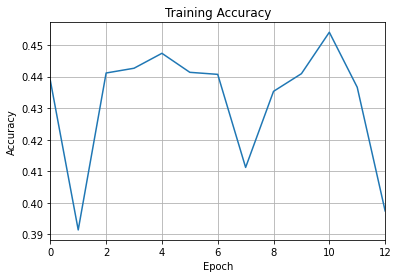

Test_accuracy 0.3875968992248062
Train with following parameters: out_channels: 127 kernel_size: 11  drop out: 0.9603483080863953 epochs: 13 batch_size: 19
Learn rate: 0.003135370587076466
Epoch: 1; Accuracy: 0.5455132343447385
Epoch: 2; Accuracy: 0.5485259307079836
Epoch: 3; Accuracy: 0.569829997848074
Epoch: 4; Accuracy: 0.5816655907036798
Epoch: 5; Accuracy: 0.5737034646008178
Epoch: 6; Accuracy: 0.5683236496664514
Epoch: 7; Accuracy: 0.5584247901872176
Epoch: 8; Accuracy: 0.562513449537336
Epoch: 9; Accuracy: 0.5638046051215838
Epoch: 10; Accuracy: 0.5470195825263611
Epoch: 11; Accuracy: 0.544006886163116
Epoch: 12; Accuracy: 0.552614590058102
Epoch: 13; Accuracy: 0.416612868517323


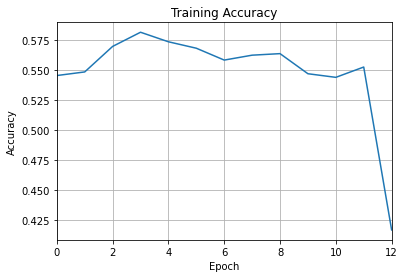

Test_accuracy 0.3763996554694229
Train with following parameters: out_channels: 127 kernel_size: 11  drop out: 0.9603483080863953 epochs: 13 batch_size: 19
Learn rate: 0.003135370587076466
Epoch: 1; Accuracy: 0.5282978265547665
Epoch: 2; Accuracy: 0.5422853453841188
Epoch: 3; Accuracy: 0.5724123090165698
Epoch: 4; Accuracy: 0.5224876264256509
Epoch: 5; Accuracy: 0.5515386270712288
Epoch: 6; Accuracy: 0.5599311383688401
Epoch: 7; Accuracy: 0.5493867010974822
Epoch: 8; Accuracy: 0.5349687970733806
Epoch: 9; Accuracy: 0.5220572412309017
Epoch: 10; Accuracy: 0.5435765009683667
Epoch: 11; Accuracy: 0.5360447600602539
Epoch: 12; Accuracy: 0.43856251344953734
Epoch: 13; Accuracy: 0.4691198622767377


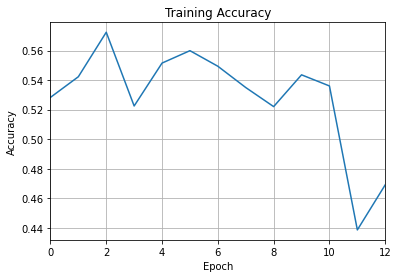

Test_accuracy 0.595176571920758
Train with following parameters: out_channels: 127 kernel_size: 11  drop out: 0.9603483080863953 epochs: 13 batch_size: 19
Learn rate: 0.003135370587076466
Epoch: 1; Accuracy: 0.5115128039595438
Epoch: 2; Accuracy: 0.5381966860340004
Epoch: 3; Accuracy: 0.508284914998924
Epoch: 4; Accuracy: 0.5414245749946202
Epoch: 5; Accuracy: 0.5517538196686034
Epoch: 6; Accuracy: 0.55390574564235
Epoch: 7; Accuracy: 0.5298041747363891
Epoch: 8; Accuracy: 0.530449752528513
Epoch: 9; Accuracy: 0.5541209382397245
Epoch: 10; Accuracy: 0.5666021088874543
Epoch: 11; Accuracy: 0.5201205078545298
Epoch: 12; Accuracy: 0.5502474714869808
Epoch: 13; Accuracy: 0.5328168710996342


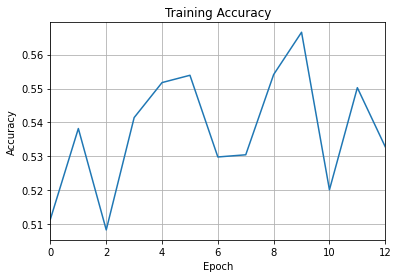

Test_accuracy 0.5107665805340224
Train with following parameters: out_channels: 127 kernel_size: 11  drop out: 0.9603483080863953 epochs: 13 batch_size: 19
Learn rate: 0.003135370587076466
Epoch: 1; Accuracy: 0.5338928340865075
Epoch: 2; Accuracy: 0.5666021088874543
Epoch: 3; Accuracy: 0.5676780718743275
Epoch: 4; Accuracy: 0.548310738110609
Epoch: 5; Accuracy: 0.5508930492791048
Epoch: 6; Accuracy: 0.5448676565526146
Epoch: 7; Accuracy: 0.5465891973316118
Epoch: 8; Accuracy: 0.49472778136432105
Epoch: 9; Accuracy: 0.5222724338282763
Epoch: 10; Accuracy: 0.5016139444803098
Epoch: 11; Accuracy: 0.47536044760060253
Epoch: 12; Accuracy: 0.513234344738541
Epoch: 13; Accuracy: 0.5323864859048849


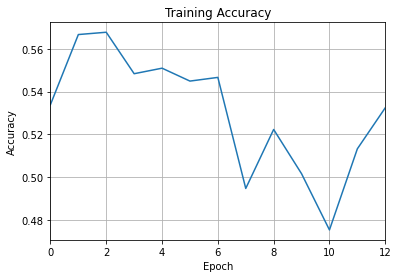

[INFO 02-06 16:34:49] ax.service.managed_loop: Running optimization trial 2...


Test_accuracy 0.5891472868217055
Test_accuracy mean value 0.49181739879414305
Train with following parameters: out_channels: 108 kernel_size: 18  drop out: 0.46579893957823515 epochs: 10 batch_size: 47
Learn rate: 0.09205622164274124


<ipython-input-8-38ab6afc99ca>:18: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



Epoch: 1; Accuracy: 0.1368624919302776
Epoch: 2; Accuracy: 0.13879922530664945
Epoch: 3; Accuracy: 0.13879922530664945
Epoch: 4; Accuracy: 0.13879922530664945
Epoch: 5; Accuracy: 0.13879922530664945
Epoch: 6; Accuracy: 0.13879922530664945
Epoch: 7; Accuracy: 0.13879922530664945
Epoch: 8; Accuracy: 0.13879922530664945
Epoch: 9; Accuracy: 0.13879922530664945
Epoch: 10; Accuracy: 0.13879922530664945


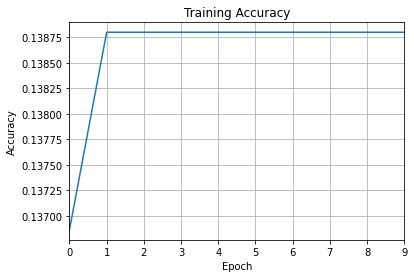

Test_accuracy 0.14125753660637383
Train with following parameters: out_channels: 108 kernel_size: 18  drop out: 0.46579893957823515 epochs: 10 batch_size: 47
Learn rate: 0.09205622164274124
Epoch: 1; Accuracy: 0.17473638906821606
Epoch: 2; Accuracy: 0.1766731224445879
Epoch: 3; Accuracy: 0.1766731224445879
Epoch: 4; Accuracy: 0.1766731224445879
Epoch: 5; Accuracy: 0.1766731224445879
Epoch: 6; Accuracy: 0.1766731224445879
Epoch: 7; Accuracy: 0.1766731224445879
Epoch: 8; Accuracy: 0.1766731224445879
Epoch: 9; Accuracy: 0.1766731224445879
Epoch: 10; Accuracy: 0.1766731224445879


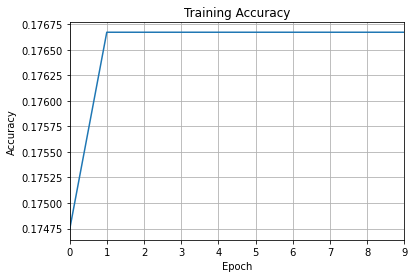

Test_accuracy 0.165374677002584
Train with following parameters: out_channels: 108 kernel_size: 18  drop out: 0.46579893957823515 epochs: 10 batch_size: 47
Learn rate: 0.09205622164274124
Epoch: 1; Accuracy: 0.1549386701097482
Epoch: 2; Accuracy: 0.15579944049924682
Epoch: 3; Accuracy: 0.15579944049924682
Epoch: 4; Accuracy: 0.15579944049924682
Epoch: 5; Accuracy: 0.15579944049924682
Epoch: 6; Accuracy: 0.15579944049924682
Epoch: 7; Accuracy: 0.15579944049924682
Epoch: 8; Accuracy: 0.15579944049924682
Epoch: 9; Accuracy: 0.15579944049924682
Epoch: 10; Accuracy: 0.15579944049924682


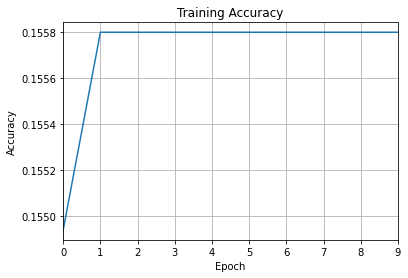

Test_accuracy 0.14556416881998277
Train with following parameters: out_channels: 108 kernel_size: 18  drop out: 0.46579893957823515 epochs: 10 batch_size: 47
Learn rate: 0.09205622164274124
Epoch: 1; Accuracy: 0.1390144179040241
Epoch: 2; Accuracy: 0.14095115128039595
Epoch: 3; Accuracy: 0.14095115128039595
Epoch: 4; Accuracy: 0.14095115128039595
Epoch: 5; Accuracy: 0.14095115128039595
Epoch: 6; Accuracy: 0.14095115128039595
Epoch: 7; Accuracy: 0.14095115128039595
Epoch: 8; Accuracy: 0.14095115128039595
Epoch: 9; Accuracy: 0.14095115128039595
Epoch: 10; Accuracy: 0.14095115128039595


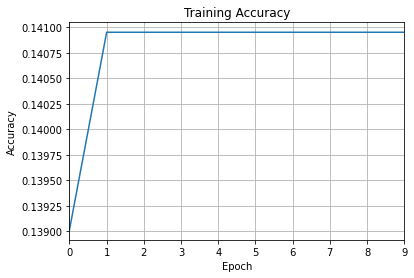

Test_accuracy 0.1326442721791559
Train with following parameters: out_channels: 108 kernel_size: 18  drop out: 0.46579893957823515 epochs: 10 batch_size: 47
Learn rate: 0.09205622164274124
Epoch: 1; Accuracy: 0.15429309231762428
Epoch: 2; Accuracy: 0.15558424790187217
Epoch: 3; Accuracy: 0.15558424790187217
Epoch: 4; Accuracy: 0.15558424790187217
Epoch: 5; Accuracy: 0.15558424790187217
Epoch: 6; Accuracy: 0.15558424790187217
Epoch: 7; Accuracy: 0.15558424790187217
Epoch: 8; Accuracy: 0.15558424790187217
Epoch: 9; Accuracy: 0.15558424790187217
Epoch: 10; Accuracy: 0.15558424790187217


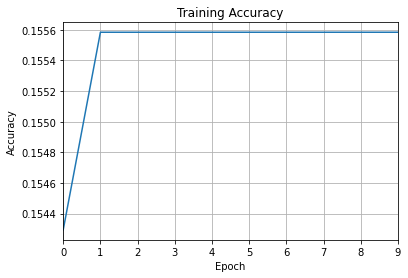

[INFO 02-06 16:37:22] ax.service.managed_loop: Running optimization trial 3...


Test_accuracy 0.14642549526270457
Test_accuracy mean value 0.14625322997416018
Train with following parameters: out_channels: 128 kernel_size: 18  drop out: 0.7589793121442199 epochs: 19 batch_size: 53
Learn rate: 1.0964169717886914e-05


<ipython-input-8-38ab6afc99ca>:18: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



Epoch: 1; Accuracy: 0.267054013341941
Epoch: 2; Accuracy: 0.31697869593285993
Epoch: 3; Accuracy: 0.38756186787174524
Epoch: 4; Accuracy: 0.41854960189369483
Epoch: 5; Accuracy: 0.48224661071659136
Epoch: 6; Accuracy: 0.6365397030342156
Epoch: 7; Accuracy: 0.7372498386055519
Epoch: 8; Accuracy: 0.788896061975468
Epoch: 9; Accuracy: 0.8082633957391866
Epoch: 10; Accuracy: 0.8179470626210459
Epoch: 11; Accuracy: 0.8254788035291586
Epoch: 12; Accuracy: 0.8272003443081558
Epoch: 13; Accuracy: 0.8274155369055305
Epoch: 14; Accuracy: 0.8360232408005165
Epoch: 15; Accuracy: 0.8334409296320207
Epoch: 16; Accuracy: 0.8407574779427588
Epoch: 17; Accuracy: 0.8431245965138799
Epoch: 18; Accuracy: 0.8459221002797503
Epoch: 19; Accuracy: 0.8454917150850011


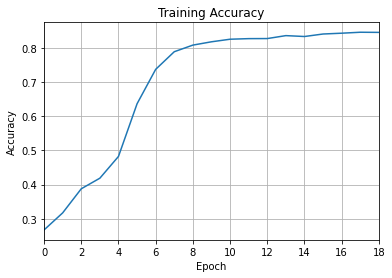

Test_accuracy 0.8208440999138673
Train with following parameters: out_channels: 128 kernel_size: 18  drop out: 0.7589793121442199 epochs: 19 batch_size: 53
Learn rate: 1.0964169717886914e-05
Epoch: 1; Accuracy: 0.2694211319130622
Epoch: 2; Accuracy: 0.32730794060684315
Epoch: 3; Accuracy: 0.4854744996772111
Epoch: 4; Accuracy: 0.5863998278459222
Epoch: 5; Accuracy: 0.6453625995265763
Epoch: 6; Accuracy: 0.7168065418549602
Epoch: 7; Accuracy: 0.7919087583387131
Epoch: 8; Accuracy: 0.8054658919733161
Epoch: 9; Accuracy: 0.819668603400043
Epoch: 10; Accuracy: 0.8254788035291586
Epoch: 11; Accuracy: 0.8287066924897784
Epoch: 12; Accuracy: 0.8351624704110179
Epoch: 13; Accuracy: 0.8414030557348827
Epoch: 14; Accuracy: 0.8439853669033786
Epoch: 15; Accuracy: 0.8459221002797503
Epoch: 16; Accuracy: 0.8528082633957392
Epoch: 17; Accuracy: 0.8525930707983645
Epoch: 18; Accuracy: 0.8562513449537336
Epoch: 19; Accuracy: 0.8564665375511082


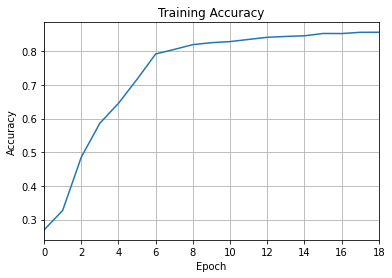

Test_accuracy 0.7691645133505599
Train with following parameters: out_channels: 128 kernel_size: 18  drop out: 0.7589793121442199 epochs: 19 batch_size: 53
Learn rate: 1.0964169717886914e-05
Epoch: 1; Accuracy: 0.2948138584032709
Epoch: 2; Accuracy: 0.35829567462879275
Epoch: 3; Accuracy: 0.5162470411017861
Epoch: 4; Accuracy: 0.6010329244673983
Epoch: 5; Accuracy: 0.6636539703034215
Epoch: 6; Accuracy: 0.7051861415967291
Epoch: 7; Accuracy: 0.7484398536690338
Epoch: 8; Accuracy: 0.7815795136647299
Epoch: 9; Accuracy: 0.807402625349688
Epoch: 10; Accuracy: 0.8190230256079191
Epoch: 11; Accuracy: 0.8265547665160319
Epoch: 12; Accuracy: 0.8293522702819023
Epoch: 13; Accuracy: 0.833225737034646
Epoch: 14; Accuracy: 0.8392511297611362
Epoch: 15; Accuracy: 0.8414030557348827
Epoch: 16; Accuracy: 0.8429094039165053
Epoch: 17; Accuracy: 0.8465676780718743
Epoch: 18; Accuracy: 0.8513019152141167
Epoch: 19; Accuracy: 0.8530234559931138


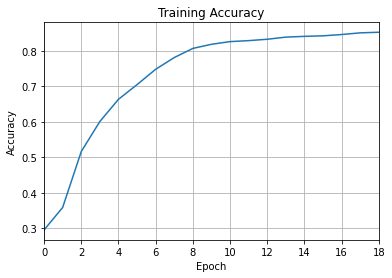

Test_accuracy 0.8053402239448751
Train with following parameters: out_channels: 128 kernel_size: 18  drop out: 0.7589793121442199 epochs: 19 batch_size: 53
Learn rate: 1.0964169717886914e-05
Epoch: 1; Accuracy: 0.29266193242952443
Epoch: 2; Accuracy: 0.31590273294598664
Epoch: 3; Accuracy: 0.40692920163546376
Epoch: 4; Accuracy: 0.5224876264256509
Epoch: 5; Accuracy: 0.5982354207015279
Epoch: 6; Accuracy: 0.63998278459221
Epoch: 7; Accuracy: 0.7049709489993544
Epoch: 8; Accuracy: 0.7619969873036367
Epoch: 9; Accuracy: 0.7878200989885948
Epoch: 10; Accuracy: 0.7957822250914569
Epoch: 11; Accuracy: 0.8050355067785668
Epoch: 12; Accuracy: 0.8080482031418119
Epoch: 13; Accuracy: 0.8132128254788036
Epoch: 14; Accuracy: 0.8185926404131698
Epoch: 15; Accuracy: 0.8218205293737896
Epoch: 16; Accuracy: 0.8228964923606628
Epoch: 17; Accuracy: 0.8254788035291586
Epoch: 18; Accuracy: 0.8306434258661503
Epoch: 19; Accuracy: 0.828921885087153


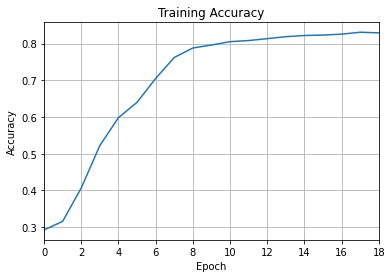

Test_accuracy 0.8682170542635659
Train with following parameters: out_channels: 128 kernel_size: 18  drop out: 0.7589793121442199 epochs: 19 batch_size: 53
Learn rate: 1.0964169717886914e-05
Epoch: 1; Accuracy: 0.28426942113191306
Epoch: 2; Accuracy: 0.33032063697008823
Epoch: 3; Accuracy: 0.3991822681299763
Epoch: 4; Accuracy: 0.5343232192812567
Epoch: 5; Accuracy: 0.5945771465461588
Epoch: 6; Accuracy: 0.6610716591349257
Epoch: 7; Accuracy: 0.71078114912847
Epoch: 8; Accuracy: 0.7204648160103292
Epoch: 9; Accuracy: 0.7370346460081774
Epoch: 10; Accuracy: 0.7658704540563804
Epoch: 11; Accuracy: 0.7899720249623413
Epoch: 12; Accuracy: 0.8015924252205724
Epoch: 13; Accuracy: 0.8114912846998064
Epoch: 14; Accuracy: 0.8108457069076824
Epoch: 15; Accuracy: 0.8190230256079191
Epoch: 16; Accuracy: 0.8218205293737896
Epoch: 17; Accuracy: 0.8250484183344093
Epoch: 18; Accuracy: 0.8334409296320207
Epoch: 19; Accuracy: 0.8340865074241446


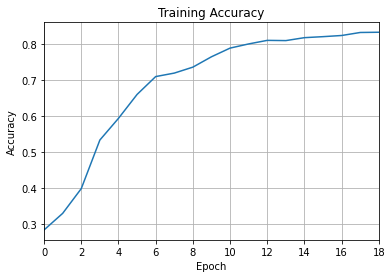

[INFO 02-06 16:42:04] ax.service.managed_loop: Running optimization trial 4...


Test_accuracy 0.8329026701119724
Test_accuracy mean value 0.8192937123169681
Train with following parameters: out_channels: 83 kernel_size: 5  drop out: 0.34110699221491814 epochs: 10 batch_size: 125
Learn rate: 0.3542014440761452


<ipython-input-8-38ab6afc99ca>:18: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



Epoch: 1; Accuracy: 0.12416612868517322
Epoch: 2; Accuracy: 0.12739401764579297
Epoch: 3; Accuracy: 0.12739401764579297
Epoch: 4; Accuracy: 0.12739401764579297
Epoch: 5; Accuracy: 0.12739401764579297
Epoch: 6; Accuracy: 0.12739401764579297
Epoch: 7; Accuracy: 0.12739401764579297
Epoch: 8; Accuracy: 0.12739401764579297
Epoch: 9; Accuracy: 0.12739401764579297
Epoch: 10; Accuracy: 0.12739401764579297


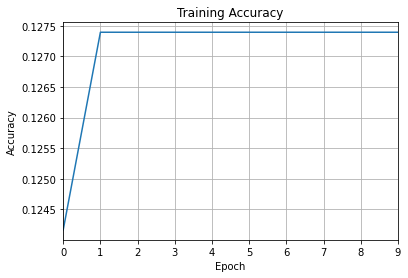

Test_accuracy 0.1335055986218777
Train with following parameters: out_channels: 83 kernel_size: 5  drop out: 0.34110699221491814 epochs: 10 batch_size: 125
Learn rate: 0.3542014440761452
Epoch: 1; Accuracy: 0.15085001075962987
Epoch: 2; Accuracy: 0.15321712933075102
Epoch: 3; Accuracy: 0.15321712933075102
Epoch: 4; Accuracy: 0.15321712933075102
Epoch: 5; Accuracy: 0.15321712933075102
Epoch: 6; Accuracy: 0.15321712933075102
Epoch: 7; Accuracy: 0.15321712933075102
Epoch: 8; Accuracy: 0.15321712933075102
Epoch: 9; Accuracy: 0.15321712933075102
Epoch: 10; Accuracy: 0.15321712933075102


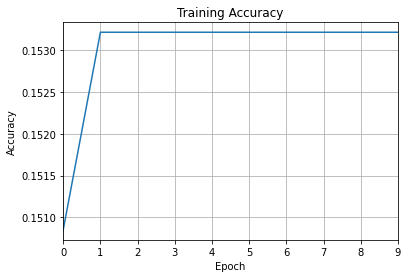

Test_accuracy 0.15590008613264428
Train with following parameters: out_channels: 83 kernel_size: 5  drop out: 0.34110699221491814 epochs: 10 batch_size: 125
Learn rate: 0.3542014440761452
Epoch: 1; Accuracy: 0.14052076608564665
Epoch: 2; Accuracy: 0.1308370992037874
Epoch: 3; Accuracy: 0.1308370992037874
Epoch: 4; Accuracy: 0.1308370992037874
Epoch: 5; Accuracy: 0.1308370992037874
Epoch: 6; Accuracy: 0.1308370992037874
Epoch: 7; Accuracy: 0.1308370992037874
Epoch: 8; Accuracy: 0.1308370992037874
Epoch: 9; Accuracy: 0.1308370992037874
Epoch: 10; Accuracy: 0.1308370992037874


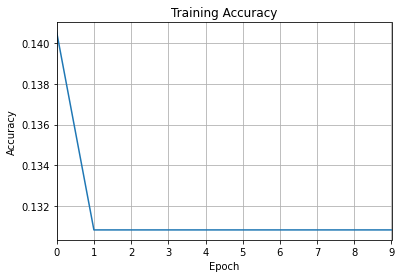

Test_accuracy 0.11972437553832903
Train with following parameters: out_channels: 83 kernel_size: 5  drop out: 0.34110699221491814 epochs: 10 batch_size: 125
Learn rate: 0.3542014440761452
Epoch: 1; Accuracy: 0.12739401764579297
Epoch: 2; Accuracy: 0.1291155584247902
Epoch: 3; Accuracy: 0.1291155584247902
Epoch: 4; Accuracy: 0.1291155584247902
Epoch: 5; Accuracy: 0.1291155584247902
Epoch: 6; Accuracy: 0.1291155584247902
Epoch: 7; Accuracy: 0.1291155584247902
Epoch: 8; Accuracy: 0.1291155584247902
Epoch: 9; Accuracy: 0.1291155584247902
Epoch: 10; Accuracy: 0.1291155584247902


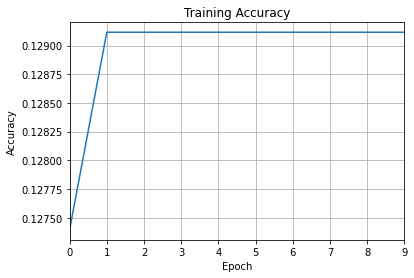

Test_accuracy 0.12661498708010335
Train with following parameters: out_channels: 83 kernel_size: 5  drop out: 0.34110699221491814 epochs: 10 batch_size: 125
Learn rate: 0.3542014440761452
Epoch: 1; Accuracy: 0.1549386701097482
Epoch: 2; Accuracy: 0.15558424790187217
Epoch: 3; Accuracy: 0.15558424790187217
Epoch: 4; Accuracy: 0.15558424790187217
Epoch: 5; Accuracy: 0.15558424790187217
Epoch: 6; Accuracy: 0.15558424790187217
Epoch: 7; Accuracy: 0.15558424790187217
Epoch: 8; Accuracy: 0.15558424790187217
Epoch: 9; Accuracy: 0.15558424790187217
Epoch: 10; Accuracy: 0.15558424790187217


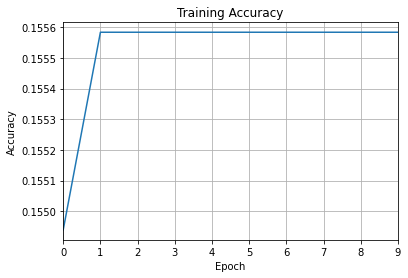

[INFO 02-06 16:43:32] ax.service.managed_loop: Running optimization trial 5...


Test_accuracy 0.14642549526270457
Test_accuracy mean value 0.13643410852713178
Train with following parameters: out_channels: 47 kernel_size: 15  drop out: 0.7849659649655223 epochs: 6 batch_size: 75
Learn rate: 0.012681489938017354


<ipython-input-8-38ab6afc99ca>:18: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



Epoch: 1; Accuracy: 0.2997632881428879
Epoch: 2; Accuracy: 0.1506348181622552
Epoch: 3; Accuracy: 0.13879922530664945
Epoch: 4; Accuracy: 0.13879922530664945
Epoch: 5; Accuracy: 0.13879922530664945
Epoch: 6; Accuracy: 0.13879922530664945


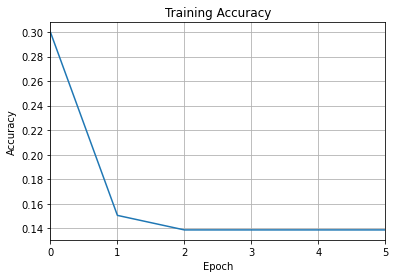

Test_accuracy 0.14125753660637383
Train with following parameters: out_channels: 47 kernel_size: 15  drop out: 0.7849659649655223 epochs: 6 batch_size: 75
Learn rate: 0.012681489938017354
Epoch: 1; Accuracy: 0.15666021088874543
Epoch: 2; Accuracy: 0.12674843985366904
Epoch: 3; Accuracy: 0.12674843985366904
Epoch: 4; Accuracy: 0.12674843985366904
Epoch: 5; Accuracy: 0.12674843985366904
Epoch: 6; Accuracy: 0.12674843985366904


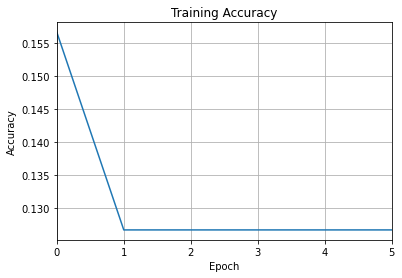

Test_accuracy 0.13608957795004306
Train with following parameters: out_channels: 47 kernel_size: 15  drop out: 0.7849659649655223 epochs: 6 batch_size: 75
Learn rate: 0.012681489938017354
Epoch: 1; Accuracy: 0.36324510436840973
Epoch: 2; Accuracy: 0.40154938670109747
Epoch: 3; Accuracy: 0.4054228534538412
Epoch: 4; Accuracy: 0.3905745642349903
Epoch: 5; Accuracy: 0.3780933935872606
Epoch: 6; Accuracy: 0.39616957176673123


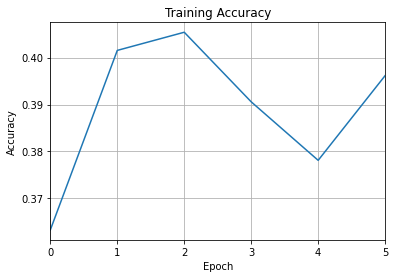

Test_accuracy 0.3807062876830319
Train with following parameters: out_channels: 47 kernel_size: 15  drop out: 0.7849659649655223 epochs: 6 batch_size: 75
Learn rate: 0.012681489938017354
Epoch: 1; Accuracy: 0.2623197761996987
Epoch: 2; Accuracy: 0.2737249838605552
Epoch: 3; Accuracy: 0.28513019152141167
Epoch: 4; Accuracy: 0.26533247256294384
Epoch: 5; Accuracy: 0.25177533892834086
Epoch: 6; Accuracy: 0.21282547880352917


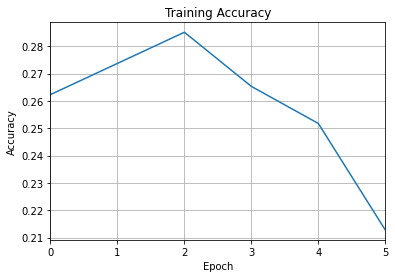

Test_accuracy 0.22997416020671835
Train with following parameters: out_channels: 47 kernel_size: 15  drop out: 0.7849659649655223 epochs: 6 batch_size: 75
Learn rate: 0.012681489938017354
Epoch: 1; Accuracy: 0.36970088228964926
Epoch: 2; Accuracy: 0.40154938670109747
Epoch: 3; Accuracy: 0.4275876909834302
Epoch: 4; Accuracy: 0.3664729933290295
Epoch: 5; Accuracy: 0.2827630729502905
Epoch: 6; Accuracy: 0.29438347320852165


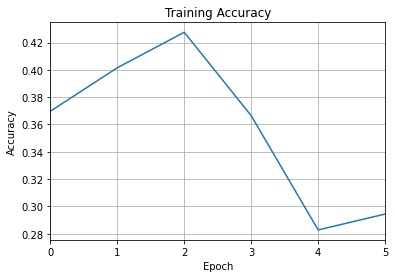

[INFO 02-06 16:44:14] ax.service.managed_loop: Running optimization trial 6...


Test_accuracy 0.32299741602067183
Test_accuracy mean value 0.24220499569336779
Train with following parameters: out_channels: 32 kernel_size: 1  drop out: 0.370727201923728 epochs: 20 batch_size: 59
Learn rate: 0.062036310250148746


<ipython-input-8-38ab6afc99ca>:18: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



Epoch: 1; Accuracy: 0.1411663438777706
Epoch: 2; Accuracy: 0.13879922530664945
Epoch: 3; Accuracy: 0.13879922530664945
Epoch: 4; Accuracy: 0.13879922530664945
Epoch: 5; Accuracy: 0.13879922530664945
Epoch: 6; Accuracy: 0.13879922530664945
Epoch: 7; Accuracy: 0.13879922530664945
Epoch: 8; Accuracy: 0.13879922530664945
Epoch: 9; Accuracy: 0.13879922530664945
Epoch: 10; Accuracy: 0.13879922530664945
Epoch: 11; Accuracy: 0.13879922530664945
Epoch: 12; Accuracy: 0.13879922530664945
Epoch: 13; Accuracy: 0.13879922530664945
Epoch: 14; Accuracy: 0.13879922530664945
Epoch: 15; Accuracy: 0.13879922530664945
Epoch: 16; Accuracy: 0.13879922530664945
Epoch: 17; Accuracy: 0.13879922530664945
Epoch: 18; Accuracy: 0.13879922530664945
Epoch: 19; Accuracy: 0.13879922530664945
Epoch: 20; Accuracy: 0.13879922530664945


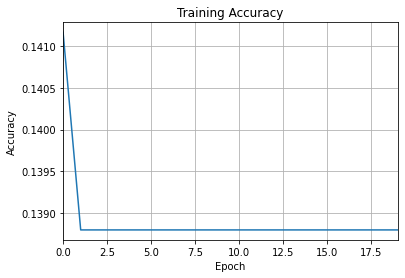

Test_accuracy 0.14125753660637383
Train with following parameters: out_channels: 32 kernel_size: 1  drop out: 0.370727201923728 epochs: 20 batch_size: 59
Learn rate: 0.062036310250148746
Epoch: 1; Accuracy: 0.17688831504196256
Epoch: 2; Accuracy: 0.1766731224445879
Epoch: 3; Accuracy: 0.1766731224445879
Epoch: 4; Accuracy: 0.1766731224445879
Epoch: 5; Accuracy: 0.1766731224445879
Epoch: 6; Accuracy: 0.1766731224445879
Epoch: 7; Accuracy: 0.1766731224445879
Epoch: 8; Accuracy: 0.1766731224445879
Epoch: 9; Accuracy: 0.1766731224445879
Epoch: 10; Accuracy: 0.1766731224445879
Epoch: 11; Accuracy: 0.1766731224445879
Epoch: 12; Accuracy: 0.1766731224445879
Epoch: 13; Accuracy: 0.1766731224445879
Epoch: 14; Accuracy: 0.1766731224445879
Epoch: 15; Accuracy: 0.1766731224445879
Epoch: 16; Accuracy: 0.1766731224445879
Epoch: 17; Accuracy: 0.1766731224445879
Epoch: 18; Accuracy: 0.1766731224445879
Epoch: 19; Accuracy: 0.1766731224445879
Epoch: 20; Accuracy: 0.1766731224445879


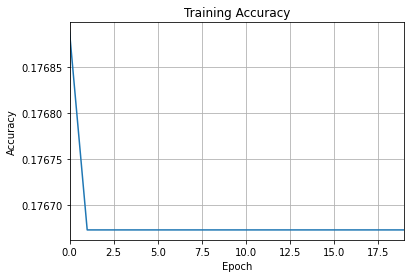

Test_accuracy 0.165374677002584
Train with following parameters: out_channels: 32 kernel_size: 1  drop out: 0.370727201923728 epochs: 20 batch_size: 59
Learn rate: 0.062036310250148746
Epoch: 1; Accuracy: 0.14353346244889176
Epoch: 2; Accuracy: 0.14267269205939315
Epoch: 3; Accuracy: 0.14267269205939315
Epoch: 4; Accuracy: 0.14267269205939315
Epoch: 5; Accuracy: 0.14267269205939315
Epoch: 6; Accuracy: 0.14267269205939315
Epoch: 7; Accuracy: 0.14267269205939315
Epoch: 8; Accuracy: 0.14267269205939315
Epoch: 9; Accuracy: 0.14267269205939315
Epoch: 10; Accuracy: 0.14267269205939315
Epoch: 11; Accuracy: 0.14267269205939315
Epoch: 12; Accuracy: 0.14267269205939315
Epoch: 13; Accuracy: 0.14267269205939315
Epoch: 14; Accuracy: 0.14267269205939315
Epoch: 15; Accuracy: 0.14267269205939315
Epoch: 16; Accuracy: 0.14267269205939315
Epoch: 17; Accuracy: 0.14267269205939315
Epoch: 18; Accuracy: 0.14267269205939315
Epoch: 19; Accuracy: 0.14267269205939315
Epoch: 20; Accuracy: 0.14267269205939315


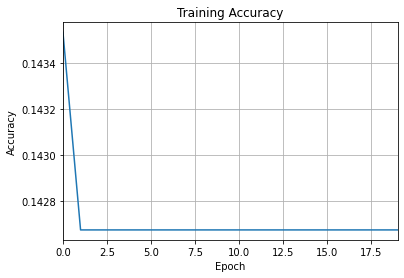

Test_accuracy 0.12575366063738158
Train with following parameters: out_channels: 32 kernel_size: 1  drop out: 0.370727201923728 epochs: 20 batch_size: 59
Learn rate: 0.062036310250148746
Epoch: 1; Accuracy: 0.15257155153862706
Epoch: 2; Accuracy: 0.15666021088874543
Epoch: 3; Accuracy: 0.15666021088874543
Epoch: 4; Accuracy: 0.15666021088874543
Epoch: 5; Accuracy: 0.15666021088874543
Epoch: 6; Accuracy: 0.15666021088874543
Epoch: 7; Accuracy: 0.15666021088874543
Epoch: 8; Accuracy: 0.15666021088874543
Epoch: 9; Accuracy: 0.15666021088874543
Epoch: 10; Accuracy: 0.15666021088874543
Epoch: 11; Accuracy: 0.15666021088874543
Epoch: 12; Accuracy: 0.15666021088874543
Epoch: 13; Accuracy: 0.15666021088874543
Epoch: 14; Accuracy: 0.15666021088874543
Epoch: 15; Accuracy: 0.15666021088874543
Epoch: 16; Accuracy: 0.15666021088874543
Epoch: 17; Accuracy: 0.15666021088874543
Epoch: 18; Accuracy: 0.15666021088874543
Epoch: 19; Accuracy: 0.15666021088874543
Epoch: 20; Accuracy: 0.15666021088874543


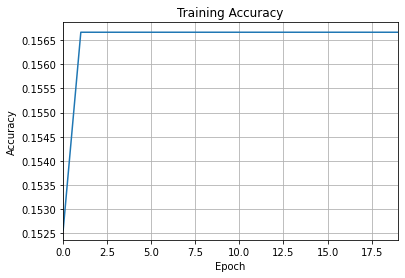

Test_accuracy 0.17054263565891473
Train with following parameters: out_channels: 32 kernel_size: 1  drop out: 0.370727201923728 epochs: 20 batch_size: 59
Learn rate: 0.062036310250148746
Epoch: 1; Accuracy: 0.12803959543791693
Epoch: 2; Accuracy: 0.12890036582741554
Epoch: 3; Accuracy: 0.12890036582741554
Epoch: 4; Accuracy: 0.12890036582741554
Epoch: 5; Accuracy: 0.12890036582741554
Epoch: 6; Accuracy: 0.12890036582741554
Epoch: 7; Accuracy: 0.12890036582741554
Epoch: 8; Accuracy: 0.12890036582741554
Epoch: 9; Accuracy: 0.12890036582741554
Epoch: 10; Accuracy: 0.12890036582741554
Epoch: 11; Accuracy: 0.12890036582741554
Epoch: 12; Accuracy: 0.12890036582741554
Epoch: 13; Accuracy: 0.12890036582741554
Epoch: 14; Accuracy: 0.12890036582741554
Epoch: 15; Accuracy: 0.12890036582741554
Epoch: 16; Accuracy: 0.12890036582741554
Epoch: 17; Accuracy: 0.12890036582741554
Epoch: 18; Accuracy: 0.12890036582741554
Epoch: 19; Accuracy: 0.12890036582741554
Epoch: 20; Accuracy: 0.12890036582741554


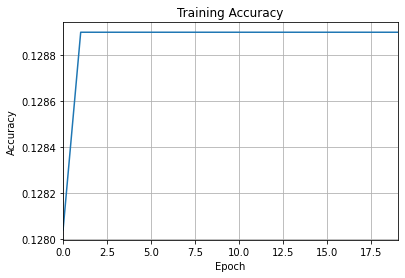

[INFO 02-06 16:45:58] ax.service.managed_loop: Running optimization trial 7...


Test_accuracy 0.12747631352282515
Test_accuracy mean value 0.14608096468561588
Train with following parameters: out_channels: 12 kernel_size: 15  drop out: 0.5596929537132382 epochs: 17 batch_size: 32
Learn rate: 3.940807780826048e-05


<ipython-input-8-38ab6afc99ca>:18: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



Epoch: 1; Accuracy: 0.19216698945556274
Epoch: 2; Accuracy: 0.3567893264471702
Epoch: 3; Accuracy: 0.49020873681945343
Epoch: 4; Accuracy: 0.5437916935657413
Epoch: 5; Accuracy: 0.591349257585539
Epoch: 6; Accuracy: 0.6255648805681084
Epoch: 7; Accuracy: 0.6466537551108242
Epoch: 8; Accuracy: 0.683666881859264
Epoch: 9; Accuracy: 0.7344523348396815
Epoch: 10; Accuracy: 0.7712502689907467
Epoch: 11; Accuracy: 0.7944910695072089
Epoch: 12; Accuracy: 0.802453195610071
Epoch: 13; Accuracy: 0.8099849365181838
Epoch: 14; Accuracy: 0.820959758984291
Epoch: 15; Accuracy: 0.8269851517107811
Epoch: 16; Accuracy: 0.8293522702819023
Epoch: 17; Accuracy: 0.8353776630083926


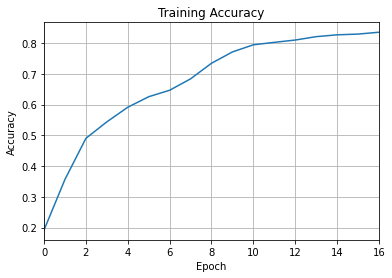

Test_accuracy 0.7588285960378983
Train with following parameters: out_channels: 12 kernel_size: 15  drop out: 0.5596929537132382 epochs: 17 batch_size: 32
Learn rate: 3.940807780826048e-05
Epoch: 1; Accuracy: 0.2715730578868087
Epoch: 2; Accuracy: 0.3348396815149559
Epoch: 3; Accuracy: 0.37335915644501827
Epoch: 4; Accuracy: 0.46739832149774047
Epoch: 5; Accuracy: 0.6268560361523564
Epoch: 6; Accuracy: 0.7269205939315687
Epoch: 7; Accuracy: 0.7557564019797719
Epoch: 8; Accuracy: 0.7682375726275016
Epoch: 9; Accuracy: 0.7772756617172369
Epoch: 10; Accuracy: 0.783946632235851
Epoch: 11; Accuracy: 0.7942758769098343
Epoch: 12; Accuracy: 0.8003012696363245
Epoch: 13; Accuracy: 0.8056810845706908
Epoch: 14; Accuracy: 0.8200989885947924
Epoch: 15; Accuracy: 0.820314181192167
Epoch: 16; Accuracy: 0.8205293737895416
Epoch: 17; Accuracy: 0.8265547665160319


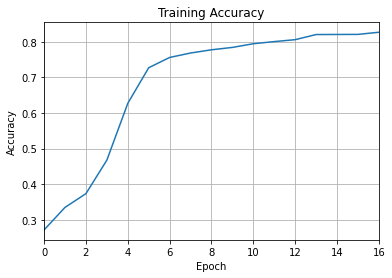

Test_accuracy 0.7459086993970715
Train with following parameters: out_channels: 12 kernel_size: 15  drop out: 0.5596929537132382 epochs: 17 batch_size: 32
Learn rate: 3.940807780826048e-05
Epoch: 1; Accuracy: 0.2530664945125888
Epoch: 2; Accuracy: 0.32214331826985154
Epoch: 3; Accuracy: 0.3819668603400043
Epoch: 4; Accuracy: 0.40585323864859046
Epoch: 5; Accuracy: 0.48525930707983644
Epoch: 6; Accuracy: 0.5846782870669249
Epoch: 7; Accuracy: 0.6741984075747794
Epoch: 8; Accuracy: 0.7303636754895632
Epoch: 9; Accuracy: 0.7529588982139015
Epoch: 10; Accuracy: 0.7740477727566172
Epoch: 11; Accuracy: 0.7968581880783301
Epoch: 12; Accuracy: 0.8015924252205724
Epoch: 13; Accuracy: 0.8119216698945556
Epoch: 14; Accuracy: 0.8151495588551754
Epoch: 15; Accuracy: 0.8220357219711641
Epoch: 16; Accuracy: 0.8248332257370347
Epoch: 17; Accuracy: 0.8237572627501614


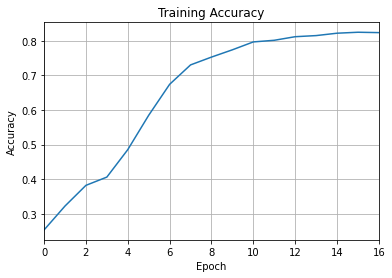

Test_accuracy 0.7545219638242894
Train with following parameters: out_channels: 12 kernel_size: 15  drop out: 0.5596929537132382 epochs: 17 batch_size: 32
Learn rate: 3.940807780826048e-05
Epoch: 1; Accuracy: 0.23821820529373788
Epoch: 2; Accuracy: 0.3326877555412094
Epoch: 3; Accuracy: 0.35786528943404344
Epoch: 4; Accuracy: 0.42995480955455134
Epoch: 5; Accuracy: 0.5315257155153863
Epoch: 6; Accuracy: 0.5758553905745643
Epoch: 7; Accuracy: 0.5911340649881645
Epoch: 8; Accuracy: 0.6042608134280181
Epoch: 9; Accuracy: 0.6352485474499677
Epoch: 10; Accuracy: 0.6823757262750162
Epoch: 11; Accuracy: 0.7077684527652249
Epoch: 12; Accuracy: 0.7482246610716591
Epoch: 13; Accuracy: 0.7785668173014848
Epoch: 14; Accuracy: 0.7863137508069722
Epoch: 15; Accuracy: 0.7977189584678287
Epoch: 16; Accuracy: 0.80611146976544
Epoch: 17; Accuracy: 0.8097697439208091


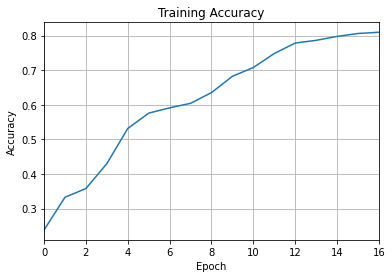

Test_accuracy 0.8570198105081827
Train with following parameters: out_channels: 12 kernel_size: 15  drop out: 0.5596929537132382 epochs: 17 batch_size: 32
Learn rate: 3.940807780826048e-05
Epoch: 1; Accuracy: 0.27824402840542284
Epoch: 2; Accuracy: 0.3118140735958683
Epoch: 3; Accuracy: 0.3847643641058748
Epoch: 4; Accuracy: 0.5031202926619325
Epoch: 5; Accuracy: 0.5579944049924682
Epoch: 6; Accuracy: 0.5911340649881645
Epoch: 7; Accuracy: 0.614159672907252
Epoch: 8; Accuracy: 0.6326662362814719
Epoch: 9; Accuracy: 0.6565526145900581
Epoch: 10; Accuracy: 0.6642995480955455
Epoch: 11; Accuracy: 0.6778566817301485
Epoch: 12; Accuracy: 0.6894770819883796
Epoch: 13; Accuracy: 0.7109963417258446
Epoch: 14; Accuracy: 0.7348827200344308
Epoch: 15; Accuracy: 0.7503765870454057
Epoch: 16; Accuracy: 0.7557564019797719
Epoch: 17; Accuracy: 0.7656552614590059


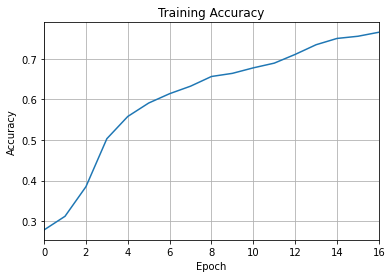

[INFO 02-06 16:46:54] ax.service.managed_loop: Running optimization trial 8...


Test_accuracy 0.7786391042204995
Test_accuracy mean value 0.7789836347975883
Train with following parameters: out_channels: 66 kernel_size: 17  drop out: 0.3996438952162862 epochs: 18 batch_size: 68
Learn rate: 0.0002263204076196099


<ipython-input-8-38ab6afc99ca>:18: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



Epoch: 1; Accuracy: 0.5112976113621691
Epoch: 2; Accuracy: 0.8151495588551754
Epoch: 3; Accuracy: 0.8495803744351195
Epoch: 4; Accuracy: 0.8693780933935873
Epoch: 5; Accuracy: 0.8775554120938239
Epoch: 6; Accuracy: 0.8846567678071874
Epoch: 7; Accuracy: 0.88616311598881
Epoch: 8; Accuracy: 0.8906821605336777
Epoch: 9; Accuracy: 0.8921885087153002
Epoch: 10; Accuracy: 0.8934796642995481
Epoch: 11; Accuracy: 0.8943404346890467
Epoch: 12; Accuracy: 0.89541639767592
Epoch: 13; Accuracy: 0.8958467828706692
Epoch: 14; Accuracy: 0.8973531310522918
Epoch: 15; Accuracy: 0.8995050570260383
Epoch: 16; Accuracy: 0.8982139014417904
Epoch: 17; Accuracy: 0.8992898644286637
Epoch: 18; Accuracy: 0.8992898644286637


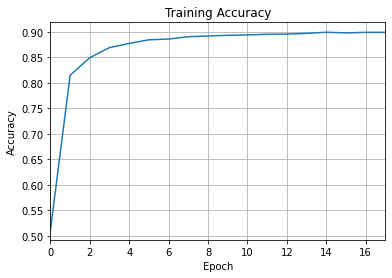

Test_accuracy 0.8372093023255814
Train with following parameters: out_channels: 66 kernel_size: 17  drop out: 0.3996438952162862 epochs: 18 batch_size: 68
Learn rate: 0.0002263204076196099
Epoch: 1; Accuracy: 0.5041962556488057
Epoch: 2; Accuracy: 0.820314181192167
Epoch: 3; Accuracy: 0.8579728857327308
Epoch: 4; Accuracy: 0.8708844415752098
Epoch: 5; Accuracy: 0.8775554120938239
Epoch: 6; Accuracy: 0.8844415752098128
Epoch: 7; Accuracy: 0.8889606197546804
Epoch: 8; Accuracy: 0.8919733161179255
Epoch: 9; Accuracy: 0.8932644717021735
Epoch: 10; Accuracy: 0.8964923606627933
Epoch: 11; Accuracy: 0.8975683236496664
Epoch: 12; Accuracy: 0.8982139014417904
Epoch: 13; Accuracy: 0.898429094039165
Epoch: 14; Accuracy: 0.9020873681945341
Epoch: 15; Accuracy: 0.9027329459866581
Epoch: 16; Accuracy: 0.9038089089735313
Epoch: 17; Accuracy: 0.9035937163761567
Epoch: 18; Accuracy: 0.9044544867656552


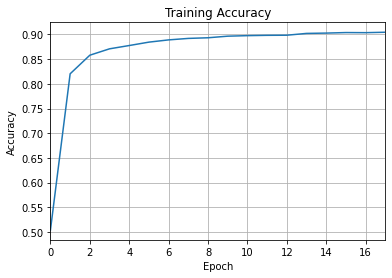

Test_accuracy 0.7958656330749354
Train with following parameters: out_channels: 66 kernel_size: 17  drop out: 0.3996438952162862 epochs: 18 batch_size: 68
Learn rate: 0.0002263204076196099
Epoch: 1; Accuracy: 0.47751237357434906
Epoch: 2; Accuracy: 0.7069076823757263
Epoch: 3; Accuracy: 0.7323004088659351
Epoch: 4; Accuracy: 0.7445663869162901
Epoch: 5; Accuracy: 0.7510221648375296
Epoch: 6; Accuracy: 0.7536044760060254
Epoch: 7; Accuracy: 0.7561867871745211
Epoch: 8; Accuracy: 0.7568323649666452
Epoch: 9; Accuracy: 0.7583387131482677
Epoch: 10; Accuracy: 0.7583387131482677
Epoch: 11; Accuracy: 0.7589842909403917
Epoch: 12; Accuracy: 0.7609210243167635
Epoch: 13; Accuracy: 0.7607058317193889
Epoch: 14; Accuracy: 0.7626425650957607
Epoch: 15; Accuracy: 0.7632881428878846
Epoch: 16; Accuracy: 0.7639337206800086
Epoch: 17; Accuracy: 0.7635033354852593
Epoch: 18; Accuracy: 0.7641489132773832


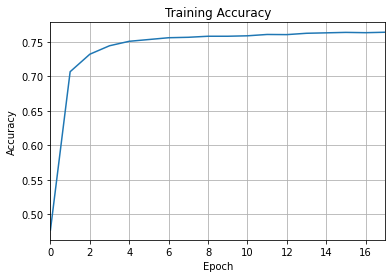

Test_accuracy 0.7347114556416882
Train with following parameters: out_channels: 66 kernel_size: 17  drop out: 0.3996438952162862 epochs: 18 batch_size: 68
Learn rate: 0.0002263204076196099
Epoch: 1; Accuracy: 0.5102216483752959
Epoch: 2; Accuracy: 0.7970733806757048
Epoch: 3; Accuracy: 0.8364536259952657
Epoch: 4; Accuracy: 0.8528082633957392
Epoch: 5; Accuracy: 0.8590488487196041
Epoch: 6; Accuracy: 0.8665805896277168
Epoch: 7; Accuracy: 0.8708844415752098
Epoch: 8; Accuracy: 0.8738971379384549
Epoch: 9; Accuracy: 0.8754034861200775
Epoch: 10; Accuracy: 0.8764794491069507
Epoch: 11; Accuracy: 0.878200989885948
Epoch: 12; Accuracy: 0.8773402194964494
Epoch: 13; Accuracy: 0.8786313750806972
Epoch: 14; Accuracy: 0.8784161824833225
Epoch: 15; Accuracy: 0.8788465676780719
Epoch: 16; Accuracy: 0.8799225306649451
Epoch: 17; Accuracy: 0.8809984936518184
Epoch: 18; Accuracy: 0.8833656122229395


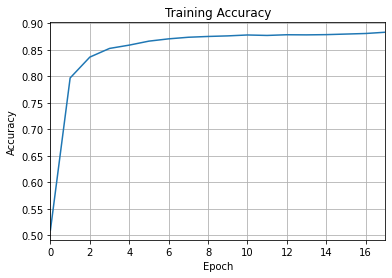

Test_accuracy 0.9250645994832042
Train with following parameters: out_channels: 66 kernel_size: 17  drop out: 0.3996438952162862 epochs: 18 batch_size: 68
Learn rate: 0.0002263204076196099
Epoch: 1; Accuracy: 0.5287282117495158
Epoch: 2; Accuracy: 0.8058962771680654
Epoch: 3; Accuracy: 0.8362384333978912
Epoch: 4; Accuracy: 0.8558209597589843
Epoch: 5; Accuracy: 0.8702388637830859
Epoch: 6; Accuracy: 0.8760490639122014
Epoch: 7; Accuracy: 0.8797073380675705
Epoch: 8; Accuracy: 0.88616311598881
Epoch: 9; Accuracy: 0.8885302345599312
Epoch: 10; Accuracy: 0.8902517753389283
Epoch: 11; Accuracy: 0.8906821605336777
Epoch: 12; Accuracy: 0.8896061975468044
Epoch: 13; Accuracy: 0.8930492791047988
Epoch: 14; Accuracy: 0.8943404346890467
Epoch: 15; Accuracy: 0.8943404346890467
Epoch: 16; Accuracy: 0.894770819883796
Epoch: 17; Accuracy: 0.8952012050785453
Epoch: 18; Accuracy: 0.8960619754680439


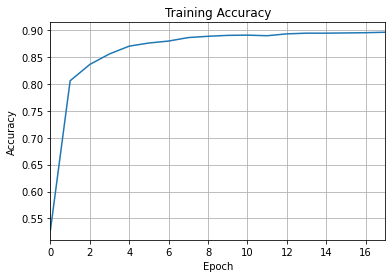

[INFO 02-06 16:49:25] ax.service.managed_loop: Running optimization trial 9...


Test_accuracy 0.8621877691645133
Test_accuracy mean value 0.8310077519379846
Train with following parameters: out_channels: 119 kernel_size: 20  drop out: 0.0034358203411102295 epochs: 20 batch_size: 125
Learn rate: 0.007952544377964662


<ipython-input-8-38ab6afc99ca>:18: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



Epoch: 1; Accuracy: 0.5457284269421132
Epoch: 2; Accuracy: 0.5683236496664514
Epoch: 3; Accuracy: 0.5978050355067785
Epoch: 4; Accuracy: 0.5997417688831505
Epoch: 5; Accuracy: 0.5541209382397245
Epoch: 6; Accuracy: 0.48913277383258014
Epoch: 7; Accuracy: 0.43942328383903595
Epoch: 8; Accuracy: 0.4777275661717237
Epoch: 9; Accuracy: 0.32278889606197547
Epoch: 10; Accuracy: 0.3610931783946632
Epoch: 11; Accuracy: 0.38734667527437056
Epoch: 12; Accuracy: 0.41381536475145253
Epoch: 13; Accuracy: 0.41166343877770606
Epoch: 14; Accuracy: 0.30686464385625134
Epoch: 15; Accuracy: 0.2765224876264257
Epoch: 16; Accuracy: 0.28426942113191306
Epoch: 17; Accuracy: 0.19195179685818808
Epoch: 18; Accuracy: 0.18506563374219928
Epoch: 19; Accuracy: 0.254142457499462
Epoch: 20; Accuracy: 0.23111684958037443


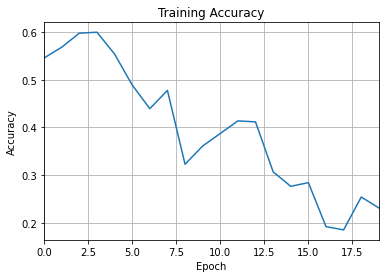

Test_accuracy 0.24892334194659776
Train with following parameters: out_channels: 119 kernel_size: 20  drop out: 0.0034358203411102295 epochs: 20 batch_size: 125
Learn rate: 0.007952544377964662
Epoch: 1; Accuracy: 0.26576285775769315
Epoch: 2; Accuracy: 0.28362384333978913
Epoch: 3; Accuracy: 0.28340865074241445
Epoch: 4; Accuracy: 0.3673337637185281
Epoch: 5; Accuracy: 0.32709274800946847
Epoch: 6; Accuracy: 0.26920593931568754
Epoch: 7; Accuracy: 0.27609210243167637
Epoch: 8; Accuracy: 0.36410587475790834
Epoch: 9; Accuracy: 0.40778997202496237
Epoch: 10; Accuracy: 0.40951151280395953
Epoch: 11; Accuracy: 0.4157520981278244
Epoch: 12; Accuracy: 0.37314396384764364
Epoch: 13; Accuracy: 0.40068861631159886
Epoch: 14; Accuracy: 0.3623843339789111
Epoch: 15; Accuracy: 0.35011835592855606
Epoch: 16; Accuracy: 0.3946632235851087
Epoch: 17; Accuracy: 0.4187647944910695
Epoch: 18; Accuracy: 0.4136001721540779
Epoch: 19; Accuracy: 0.39789111254572845
Epoch: 20; Accuracy: 0.381536475145255


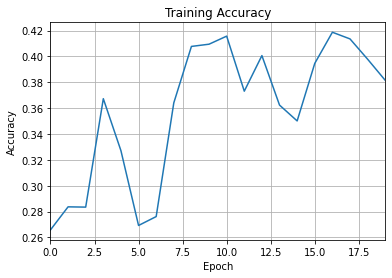

Test_accuracy 0.3772609819121447
Train with following parameters: out_channels: 119 kernel_size: 20  drop out: 0.0034358203411102295 epochs: 20 batch_size: 125
Learn rate: 0.007952544377964662
Epoch: 1; Accuracy: 0.2722186356789326
Epoch: 2; Accuracy: 0.2918011620400258
Epoch: 3; Accuracy: 0.26877555412093823
Epoch: 4; Accuracy: 0.2801807617817947
Epoch: 5; Accuracy: 0.2866365397030342
Epoch: 6; Accuracy: 0.29438347320852165
Epoch: 7; Accuracy: 0.2956746287927695
Epoch: 8; Accuracy: 0.2971809769743921
Epoch: 9; Accuracy: 0.29309231762427373
Epoch: 10; Accuracy: 0.2913707768452765
Epoch: 11; Accuracy: 0.2963202065848935
Epoch: 12; Accuracy: 0.2967505917796428
Epoch: 13; Accuracy: 0.29825693996126534
Epoch: 14; Accuracy: 0.2989025177533893
Epoch: 15; Accuracy: 0.2989025177533893
Epoch: 16; Accuracy: 0.29911771035076395
Epoch: 17; Accuracy: 0.2586615020443297
Epoch: 18; Accuracy: 0.2922315472347751
Epoch: 19; Accuracy: 0.2831934581450398
Epoch: 20; Accuracy: 0.27458575425005377


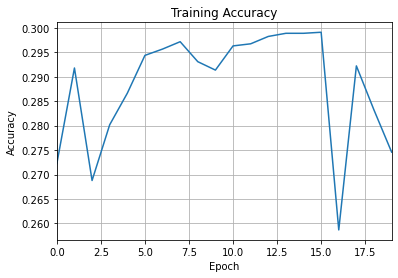

Test_accuracy 0.29285099052540914
Train with following parameters: out_channels: 119 kernel_size: 20  drop out: 0.0034358203411102295 epochs: 20 batch_size: 125
Learn rate: 0.007952544377964662
Epoch: 1; Accuracy: 0.3490423929416828
Epoch: 2; Accuracy: 0.42457499462018505
Epoch: 3; Accuracy: 0.3475360447600603
Epoch: 4; Accuracy: 0.3247256294383473
Epoch: 5; Accuracy: 0.4032709274800947
Epoch: 6; Accuracy: 0.4041316978695933
Epoch: 7; Accuracy: 0.30729502905100065
Epoch: 8; Accuracy: 0.3012696363245104
Epoch: 9; Accuracy: 0.3148267699591134
Epoch: 10; Accuracy: 0.3204217774908543
Epoch: 11; Accuracy: 0.3204217774908543
Epoch: 12; Accuracy: 0.3174090811276092
Epoch: 13; Accuracy: 0.31676350333548525
Epoch: 14; Accuracy: 0.2526361093178395
Epoch: 15; Accuracy: 0.1715085001075963
Epoch: 16; Accuracy: 0.15666021088874543
Epoch: 17; Accuracy: 0.15666021088874543
Epoch: 18; Accuracy: 0.15666021088874543
Epoch: 19; Accuracy: 0.15666021088874543
Epoch: 20; Accuracy: 0.15666021088874543


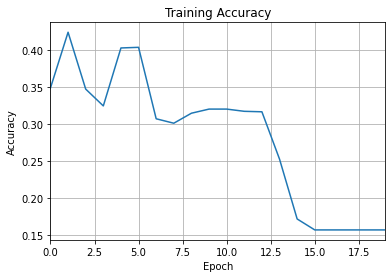

Test_accuracy 0.17054263565891473
Train with following parameters: out_channels: 119 kernel_size: 20  drop out: 0.0034358203411102295 epochs: 20 batch_size: 125
Learn rate: 0.007952544377964662
Epoch: 1; Accuracy: 0.17645792984721326
Epoch: 2; Accuracy: 0.1573057886808694
Epoch: 3; Accuracy: 0.1573057886808694
Epoch: 4; Accuracy: 0.1573057886808694
Epoch: 5; Accuracy: 0.1573057886808694
Epoch: 6; Accuracy: 0.1573057886808694
Epoch: 7; Accuracy: 0.1573057886808694
Epoch: 8; Accuracy: 0.1573057886808694
Epoch: 9; Accuracy: 0.1573057886808694
Epoch: 10; Accuracy: 0.1573057886808694
Epoch: 11; Accuracy: 0.1573057886808694
Epoch: 12; Accuracy: 0.1573057886808694
Epoch: 13; Accuracy: 0.1573057886808694
Epoch: 14; Accuracy: 0.1573057886808694
Epoch: 15; Accuracy: 0.1573057886808694
Epoch: 16; Accuracy: 0.1573057886808694
Epoch: 17; Accuracy: 0.1573057886808694
Epoch: 18; Accuracy: 0.1573057886808694
Epoch: 19; Accuracy: 0.1573057886808694
Epoch: 20; Accuracy: 0.1573057886808694


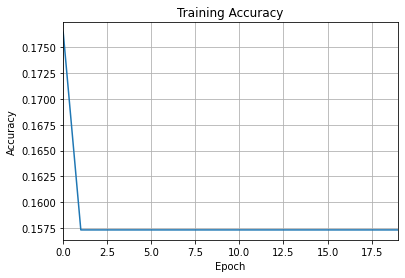

[INFO 02-06 16:54:23] ax.service.managed_loop: Running optimization trial 10...


Test_accuracy 0.16795865633074936
Test_accuracy mean value 0.25150732127476316
Train with following parameters: out_channels: 32 kernel_size: 8  drop out: 0.41757291834801435 epochs: 9 batch_size: 32
Learn rate: 2.9426827069297825e-06


<ipython-input-8-38ab6afc99ca>:18: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



Epoch: 1; Accuracy: 0.1945341080266839
Epoch: 2; Accuracy: 0.2494082203572197
Epoch: 3; Accuracy: 0.2014202711426727
Epoch: 4; Accuracy: 0.20098988594792339
Epoch: 5; Accuracy: 0.23563589412524208
Epoch: 6; Accuracy: 0.29287712502689905
Epoch: 7; Accuracy: 0.32558639982784593
Epoch: 8; Accuracy: 0.3486120077469335
Epoch: 9; Accuracy: 0.3561437486550463


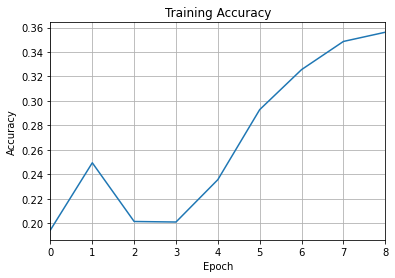

Test_accuracy 0.35572782084409993
Train with following parameters: out_channels: 32 kernel_size: 8  drop out: 0.41757291834801435 epochs: 9 batch_size: 32
Learn rate: 2.9426827069297825e-06
Epoch: 1; Accuracy: 0.23929416828061115
Epoch: 2; Accuracy: 0.36432106735528297
Epoch: 3; Accuracy: 0.35076393372068
Epoch: 4; Accuracy: 0.3572197116419195
Epoch: 5; Accuracy: 0.37357434904239295
Epoch: 6; Accuracy: 0.3561437486550463
Epoch: 7; Accuracy: 0.33613083709920377
Epoch: 8; Accuracy: 0.3240800516462234
Epoch: 9; Accuracy: 0.3189154293092318


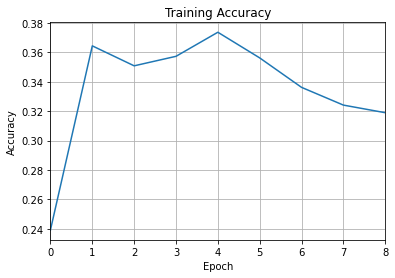

Test_accuracy 0.3298880275624462
Train with following parameters: out_channels: 32 kernel_size: 8  drop out: 0.41757291834801435 epochs: 9 batch_size: 32
Learn rate: 2.9426827069297825e-06
Epoch: 1; Accuracy: 0.22035721971164193
Epoch: 2; Accuracy: 0.32128254788035293
Epoch: 3; Accuracy: 0.31633311814073595
Epoch: 4; Accuracy: 0.311383688401119
Epoch: 5; Accuracy: 0.3055734882720034
Epoch: 6; Accuracy: 0.3053582956746288
Epoch: 7; Accuracy: 0.30471271788250487
Epoch: 8; Accuracy: 0.3044975252851302
Epoch: 9; Accuracy: 0.30471271788250487


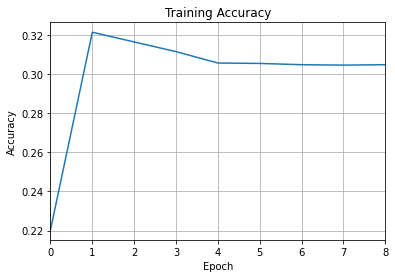

Test_accuracy 0.3143841515934539
Train with following parameters: out_channels: 32 kernel_size: 8  drop out: 0.41757291834801435 epochs: 9 batch_size: 32
Learn rate: 2.9426827069297825e-06
Epoch: 1; Accuracy: 0.11254572842694212
Epoch: 2; Accuracy: 0.2582311168495804
Epoch: 3; Accuracy: 0.2537120723047127
Epoch: 4; Accuracy: 0.2317624273724984
Epoch: 5; Accuracy: 0.23671185711211534
Epoch: 6; Accuracy: 0.254142457499462
Epoch: 7; Accuracy: 0.2726490208736819
Epoch: 8; Accuracy: 0.284914998924037
Epoch: 9; Accuracy: 0.32063697008822895


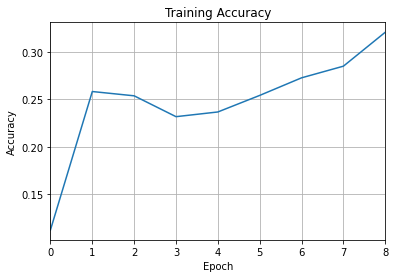

Test_accuracy 0.3643410852713178
Train with following parameters: out_channels: 32 kernel_size: 8  drop out: 0.41757291834801435 epochs: 9 batch_size: 32
Learn rate: 2.9426827069297825e-06
Epoch: 1; Accuracy: 0.21239509360877987
Epoch: 2; Accuracy: 0.31504196255648803
Epoch: 3; Accuracy: 0.3146115773617388
Epoch: 4; Accuracy: 0.3066494512588767
Epoch: 5; Accuracy: 0.30471271788250487
Epoch: 6; Accuracy: 0.3051431030772541
Epoch: 7; Accuracy: 0.30471271788250487
Epoch: 8; Accuracy: 0.3057886808693781
Epoch: 9; Accuracy: 0.3066494512588767


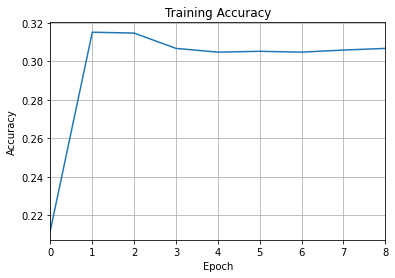

[INFO 02-06 16:55:09] ax.service.managed_loop: Running optimization trial 11...


Test_accuracy 0.3049095607235142
Test_accuracy mean value 0.3338501291989664
Train with following parameters: out_channels: 34 kernel_size: 14  drop out: 0.9964951761066914 epochs: 10 batch_size: 80
Learn rate: 0.001861689645264638


<ipython-input-8-38ab6afc99ca>:18: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



Epoch: 1; Accuracy: 0.2625349687970734
Epoch: 2; Accuracy: 0.35313105229180114
Epoch: 3; Accuracy: 0.38691629007962125
Epoch: 4; Accuracy: 0.4054228534538412
Epoch: 5; Accuracy: 0.42500537981493436
Epoch: 6; Accuracy: 0.4323219281256725
Epoch: 7; Accuracy: 0.4265117279965569
Epoch: 8; Accuracy: 0.41897998708844414
Epoch: 9; Accuracy: 0.43554981708629226
Epoch: 10; Accuracy: 0.43899289864428664


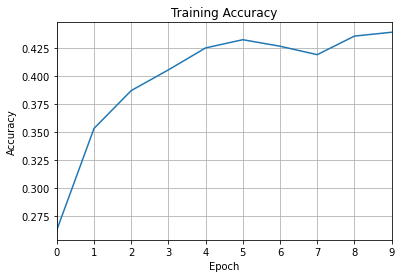

Test_accuracy 0.4117140396210164
Train with following parameters: out_channels: 34 kernel_size: 14  drop out: 0.9964951761066914 epochs: 10 batch_size: 80
Learn rate: 0.001861689645264638
Epoch: 1; Accuracy: 0.27178825048418337
Epoch: 2; Accuracy: 0.3606627931999139
Epoch: 3; Accuracy: 0.40262534968797076
Epoch: 4; Accuracy: 0.4260813428018076
Epoch: 5; Accuracy: 0.43511943189154295
Epoch: 6; Accuracy: 0.43339789111254573
Epoch: 7; Accuracy: 0.4409296320206585
Epoch: 8; Accuracy: 0.45298041747363893
Epoch: 9; Accuracy: 0.43899289864428664
Epoch: 10; Accuracy: 0.44717021734452334


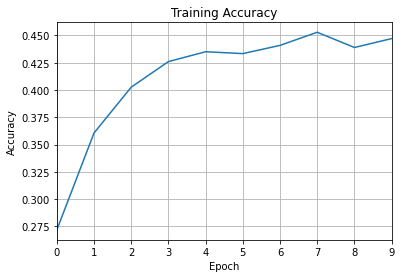

Test_accuracy 0.42377260981912146
Train with following parameters: out_channels: 34 kernel_size: 14  drop out: 0.9964951761066914 epochs: 10 batch_size: 80
Learn rate: 0.001861689645264638
Epoch: 1; Accuracy: 0.2593070798364536
Epoch: 2; Accuracy: 0.3604476006025393
Epoch: 3; Accuracy: 0.39143533462448893
Epoch: 4; Accuracy: 0.4049924682590919
Epoch: 5; Accuracy: 0.4088659350118356
Epoch: 6; Accuracy: 0.4140305573488272
Epoch: 7; Accuracy: 0.42500537981493436
Epoch: 8; Accuracy: 0.4310307725414246
Epoch: 9; Accuracy: 0.4368409726705401
Epoch: 10; Accuracy: 0.4312459651387992


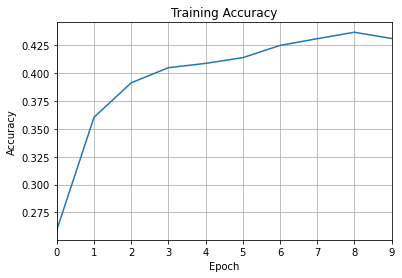

Test_accuracy 0.4582256675279931
Train with following parameters: out_channels: 34 kernel_size: 14  drop out: 0.9964951761066914 epochs: 10 batch_size: 80
Learn rate: 0.001861689645264638
Epoch: 1; Accuracy: 0.25995265762857755
Epoch: 2; Accuracy: 0.3576500968366688
Epoch: 3; Accuracy: 0.38605551969012264
Epoch: 4; Accuracy: 0.4039165052722186
Epoch: 5; Accuracy: 0.4041316978695933
Epoch: 6; Accuracy: 0.3983214977404777
Epoch: 7; Accuracy: 0.4136001721540779
Epoch: 8; Accuracy: 0.41424574994620184
Epoch: 9; Accuracy: 0.4219926834516893
Epoch: 10; Accuracy: 0.4228534538411879


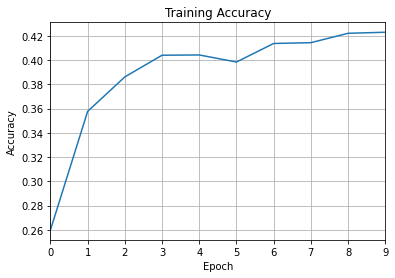

Test_accuracy 0.5073212747631353
Train with following parameters: out_channels: 34 kernel_size: 14  drop out: 0.9964951761066914 epochs: 10 batch_size: 80
Learn rate: 0.001861689645264638
Epoch: 1; Accuracy: 0.26554766516031847
Epoch: 2; Accuracy: 0.35463740047342374
Epoch: 3; Accuracy: 0.3940176457929847
Epoch: 4; Accuracy: 0.41424574994620184
Epoch: 5; Accuracy: 0.41381536475145253
Epoch: 6; Accuracy: 0.41984075747794275
Epoch: 7; Accuracy: 0.42048633527006674
Epoch: 8; Accuracy: 0.41467613514095114
Epoch: 9; Accuracy: 0.42543576500968366
Epoch: 10; Accuracy: 0.4312459651387992


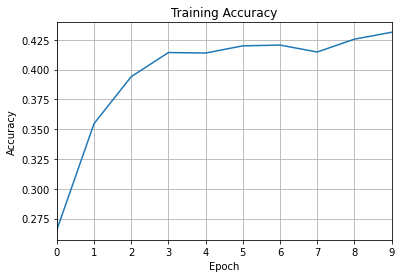

[INFO 02-06 16:55:59] ax.service.managed_loop: Running optimization trial 12...


Test_accuracy 0.4909560723514212
Test_accuracy mean value 0.4583979328165375
Train with following parameters: out_channels: 71 kernel_size: 13  drop out: 0.4231686992570758 epochs: 14 batch_size: 36
Learn rate: 0.0019317545327739926


<ipython-input-8-38ab6afc99ca>:18: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



Epoch: 1; Accuracy: 0.5702603830428233
Epoch: 2; Accuracy: 0.5950075317409081
Epoch: 3; Accuracy: 0.5917796427802884
Epoch: 4; Accuracy: 0.6051215838175167
Epoch: 5; Accuracy: 0.60619754680439
Epoch: 6; Accuracy: 0.5952227243382827
Epoch: 7; Accuracy: 0.5945771465461588
Epoch: 8; Accuracy: 0.5930707983645362
Epoch: 9; Accuracy: 0.6100710135571337
Epoch: 10; Accuracy: 0.6132989025177534
Epoch: 11; Accuracy: 0.6122229395308801
Epoch: 12; Accuracy: 0.6096406283623843
Epoch: 13; Accuracy: 0.6113621691413815
Epoch: 14; Accuracy: 0.5674628792769528


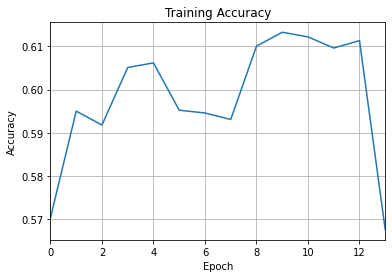

Test_accuracy 0.5297157622739018
Train with following parameters: out_channels: 71 kernel_size: 13  drop out: 0.4231686992570758 epochs: 14 batch_size: 36
Learn rate: 0.0019317545327739926
Epoch: 1; Accuracy: 0.6632235851086723
Epoch: 2; Accuracy: 0.7434904239294168
Epoch: 3; Accuracy: 0.7570475575640198
Epoch: 4; Accuracy: 0.7566171723692705
Epoch: 5; Accuracy: 0.7652248762642565
Epoch: 6; Accuracy: 0.7533892834086507
Epoch: 7; Accuracy: 0.7398321497740478
Epoch: 8; Accuracy: 0.7303636754895632
Epoch: 9; Accuracy: 0.6982999784807402
Epoch: 10; Accuracy: 0.7239078975683236
Epoch: 11; Accuracy: 0.7411233053582956
Epoch: 12; Accuracy: 0.7531740908112761
Epoch: 13; Accuracy: 0.7503765870454057
Epoch: 14; Accuracy: 0.7585539057456423


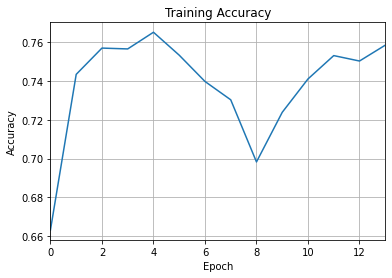

Test_accuracy 0.6933677863910422
Train with following parameters: out_channels: 71 kernel_size: 13  drop out: 0.4231686992570758 epochs: 14 batch_size: 36
Learn rate: 0.0019317545327739926
Epoch: 1; Accuracy: 0.679363029911771
Epoch: 2; Accuracy: 0.7529588982139015
Epoch: 3; Accuracy: 0.7419840757477942
Epoch: 4; Accuracy: 0.7471486980847859
Epoch: 5; Accuracy: 0.7482246610716591
Epoch: 6; Accuracy: 0.7589842909403917
Epoch: 7; Accuracy: 0.7536044760060254
Epoch: 8; Accuracy: 0.7402625349687971
Epoch: 9; Accuracy: 0.7557564019797719
Epoch: 10; Accuracy: 0.7609210243167635
Epoch: 11; Accuracy: 0.7561867871745211
Epoch: 12; Accuracy: 0.7572627501613944
Epoch: 13; Accuracy: 0.7497310092532817
Epoch: 14; Accuracy: 0.7239078975683236


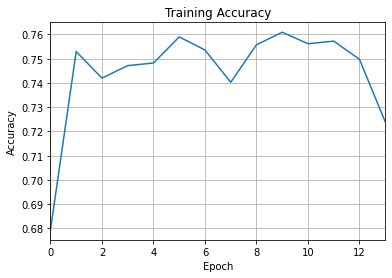

Test_accuracy 0.7002583979328165
Train with following parameters: out_channels: 71 kernel_size: 13  drop out: 0.4231686992570758 epochs: 14 batch_size: 36
Learn rate: 0.0019317545327739926
Epoch: 1; Accuracy: 0.5448676565526146
Epoch: 2; Accuracy: 0.5941467613514095
Epoch: 3; Accuracy: 0.5842479018721756
Epoch: 4; Accuracy: 0.5941467613514095
Epoch: 5; Accuracy: 0.5818807833010544
Epoch: 6; Accuracy: 0.5950075317409081
Epoch: 7; Accuracy: 0.5941467613514095
Epoch: 8; Accuracy: 0.584032709274801
Epoch: 9; Accuracy: 0.5879061760275447
Epoch: 10; Accuracy: 0.5915644501829137
Epoch: 11; Accuracy: 0.5939315687540349
Epoch: 12; Accuracy: 0.582741553690553
Epoch: 13; Accuracy: 0.5982354207015279
Epoch: 14; Accuracy: 0.5993113836884011


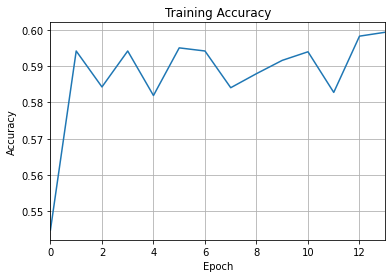

Test_accuracy 0.6589147286821705
Train with following parameters: out_channels: 71 kernel_size: 13  drop out: 0.4231686992570758 epochs: 14 batch_size: 36
Learn rate: 0.0019317545327739926
Epoch: 1; Accuracy: 0.6556918442005595
Epoch: 2; Accuracy: 0.7344523348396815
Epoch: 3; Accuracy: 0.7449967721110394
Epoch: 4; Accuracy: 0.7497310092532817
Epoch: 5; Accuracy: 0.7536044760060254
Epoch: 6; Accuracy: 0.760060253927265
Epoch: 7; Accuracy: 0.760060253927265
Epoch: 8; Accuracy: 0.7505917796427803
Epoch: 9; Accuracy: 0.7381106089950505
Epoch: 10; Accuracy: 0.741553690553045
Epoch: 11; Accuracy: 0.7525285130191521
Epoch: 12; Accuracy: 0.7400473423714224
Epoch: 13; Accuracy: 0.7394017645792985
Epoch: 14; Accuracy: 0.7516677426296535


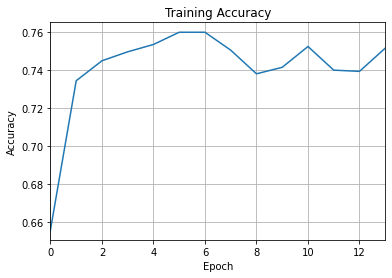

[INFO 02-06 17:00:04] ax.service.managed_loop: Running optimization trial 13...


Test_accuracy 0.7174849267872524
Test_accuracy mean value 0.6599483204134368


<ipython-input-8-38ab6afc99ca>:18: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



Train with following parameters: out_channels: 74 kernel_size: 16  drop out: 0.5917880185557617 epochs: 18 batch_size: 48
Learn rate: 5.588619086372069e-05
Epoch: 1; Accuracy: 0.3384979556703249
Epoch: 2; Accuracy: 0.672046481601033
Epoch: 3; Accuracy: 0.8080482031418119
Epoch: 4; Accuracy: 0.825909188723908
Epoch: 5; Accuracy: 0.8439853669033786
Epoch: 6; Accuracy: 0.8500107596298687
Epoch: 7; Accuracy: 0.8562513449537336
Epoch: 8; Accuracy: 0.8624919302775984
Epoch: 9; Accuracy: 0.8674413600172154
Epoch: 10; Accuracy: 0.872605982354207
Epoch: 11; Accuracy: 0.8760490639122014
Epoch: 12; Accuracy: 0.8773402194964494
Epoch: 13; Accuracy: 0.8797073380675705
Epoch: 14; Accuracy: 0.8833656122229395
Epoch: 15; Accuracy: 0.885517538196686
Epoch: 16; Accuracy: 0.8880998493651818
Epoch: 17; Accuracy: 0.8887454271573058
Epoch: 18; Accuracy: 0.8900365827415537


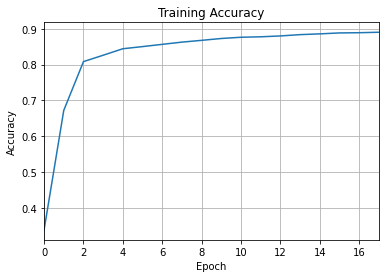

Test_accuracy 0.8492678725236865
Train with following parameters: out_channels: 74 kernel_size: 16  drop out: 0.5917880185557617 epochs: 18 batch_size: 48
Learn rate: 5.588619086372069e-05
Epoch: 1; Accuracy: 0.39746072735097915
Epoch: 2; Accuracy: 0.7421992683451689
Epoch: 3; Accuracy: 0.8145039810630514
Epoch: 4; Accuracy: 0.8373143963847643
Epoch: 5; Accuracy: 0.8534538411878632
Epoch: 6; Accuracy: 0.8659350118355928
Epoch: 7; Accuracy: 0.8758338713148268
Epoch: 8; Accuracy: 0.8762642565095761
Epoch: 9; Accuracy: 0.8825048418334409
Epoch: 10; Accuracy: 0.885517538196686
Epoch: 11; Accuracy: 0.8865935011835593
Epoch: 12; Accuracy: 0.889821390144179
Epoch: 13; Accuracy: 0.8934796642995481
Epoch: 14; Accuracy: 0.8945556272864214
Epoch: 15; Accuracy: 0.8964923606627933
Epoch: 16; Accuracy: 0.8960619754680439
Epoch: 17; Accuracy: 0.8982139014417904
Epoch: 18; Accuracy: 0.8973531310522918


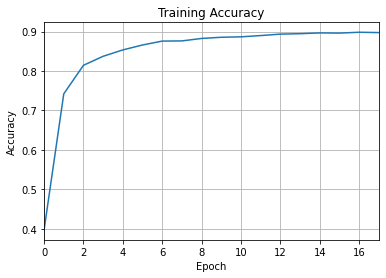

Test_accuracy 0.8130921619293713
Train with following parameters: out_channels: 74 kernel_size: 16  drop out: 0.5917880185557617 epochs: 18 batch_size: 48
Learn rate: 5.588619086372069e-05
Epoch: 1; Accuracy: 0.3888530234559931
Epoch: 2; Accuracy: 0.6064127394017645
Epoch: 3; Accuracy: 0.697224015493867
Epoch: 4; Accuracy: 0.7245534753604476
Epoch: 5; Accuracy: 0.7305788680869378
Epoch: 6; Accuracy: 0.732945986658059
Epoch: 7; Accuracy: 0.7357434904239294
Epoch: 8; Accuracy: 0.7368194534108027
Epoch: 9; Accuracy: 0.7381106089950505
Epoch: 10; Accuracy: 0.7387561867871745
Epoch: 11; Accuracy: 0.7387561867871745
Epoch: 12; Accuracy: 0.7394017645792985
Epoch: 13; Accuracy: 0.7400473423714224
Epoch: 14; Accuracy: 0.7411233053582956
Epoch: 15; Accuracy: 0.7398321497740478
Epoch: 16; Accuracy: 0.7398321497740478
Epoch: 17; Accuracy: 0.7402625349687971
Epoch: 18; Accuracy: 0.7409081127609211


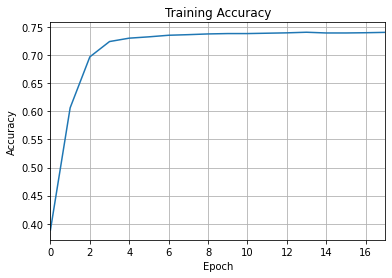

Test_accuracy 0.6959517657192076
Train with following parameters: out_channels: 74 kernel_size: 16  drop out: 0.5917880185557617 epochs: 18 batch_size: 48
Learn rate: 5.588619086372069e-05
Epoch: 1; Accuracy: 0.36927049709489995
Epoch: 2; Accuracy: 0.627071228749731
Epoch: 3; Accuracy: 0.7805035506778567
Epoch: 4; Accuracy: 0.8179470626210459
Epoch: 5; Accuracy: 0.8327953518398967
Epoch: 6; Accuracy: 0.8439853669033786
Epoch: 7; Accuracy: 0.8480740262534969
Epoch: 8; Accuracy: 0.8573273079406069
Epoch: 9; Accuracy: 0.8618463524854745
Epoch: 10; Accuracy: 0.8627071228749731
Epoch: 11; Accuracy: 0.8674413600172154
Epoch: 12; Accuracy: 0.8687325156014634
Epoch: 13; Accuracy: 0.8708844415752098
Epoch: 14; Accuracy: 0.8743275231332042
Epoch: 15; Accuracy: 0.8747579083279535
Epoch: 16; Accuracy: 0.8749731009253282
Epoch: 17; Accuracy: 0.8769098343017
Epoch: 18; Accuracy: 0.8771250268990747


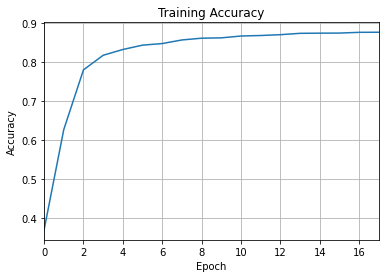

Test_accuracy 0.9130060292850991
Train with following parameters: out_channels: 74 kernel_size: 16  drop out: 0.5917880185557617 epochs: 18 batch_size: 48
Learn rate: 5.588619086372069e-05
Epoch: 1; Accuracy: 0.342156229825694
Epoch: 2; Accuracy: 0.5978050355067785
Epoch: 3; Accuracy: 0.7114267269205939
Epoch: 4; Accuracy: 0.8149343662578007
Epoch: 5; Accuracy: 0.8368840111900151
Epoch: 6; Accuracy: 0.8487196040456209
Epoch: 7; Accuracy: 0.8566817301484829
Epoch: 8; Accuracy: 0.863352700667097
Epoch: 9; Accuracy: 0.8693780933935873
Epoch: 10; Accuracy: 0.8754034861200775
Epoch: 11; Accuracy: 0.8773402194964494
Epoch: 12; Accuracy: 0.881859264041317
Epoch: 13; Accuracy: 0.8859479233914354
Epoch: 14; Accuracy: 0.8870238863783085
Epoch: 15; Accuracy: 0.8883150419625565
Epoch: 16; Accuracy: 0.8887454271573058
Epoch: 17; Accuracy: 0.8896061975468044
Epoch: 18; Accuracy: 0.8913277383258016


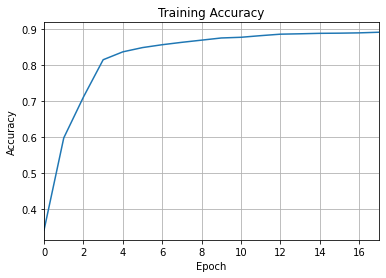

[INFO 02-06 17:02:53] ax.service.managed_loop: Running optimization trial 14...


Test_accuracy 0.8604651162790697
Test_accuracy mean value 0.8263565891472868


<ipython-input-8-38ab6afc99ca>:18: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



Train with following parameters: out_channels: 46 kernel_size: 17  drop out: 0.46888114913744255 epochs: 17 batch_size: 49
Learn rate: 0.00011740616642569329
Epoch: 1; Accuracy: 0.3948784161824833
Epoch: 2; Accuracy: 0.7234775123735744
Epoch: 3; Accuracy: 0.8291370776845276
Epoch: 4; Accuracy: 0.8538842263826124
Epoch: 5; Accuracy: 0.8661502044329675
Epoch: 6; Accuracy: 0.8786313750806972
Epoch: 7; Accuracy: 0.8827200344308156
Epoch: 8; Accuracy: 0.8876694641704326
Epoch: 9; Accuracy: 0.8911125457284269
Epoch: 10; Accuracy: 0.8943404346890467
Epoch: 11; Accuracy: 0.8964923606627933
Epoch: 12; Accuracy: 0.8960619754680439
Epoch: 13; Accuracy: 0.899074671831289
Epoch: 14; Accuracy: 0.8971379384549172
Epoch: 15; Accuracy: 0.898429094039165
Epoch: 16; Accuracy: 0.9016569829997848
Epoch: 17; Accuracy: 0.9027329459866581


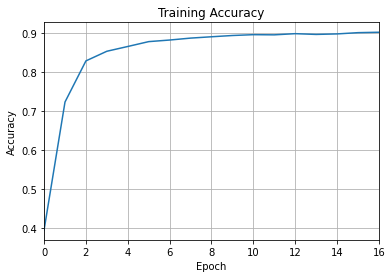

Test_accuracy 0.8329026701119724
Train with following parameters: out_channels: 46 kernel_size: 17  drop out: 0.46888114913744255 epochs: 17 batch_size: 49
Learn rate: 0.00011740616642569329
Epoch: 1; Accuracy: 0.395093608779858
Epoch: 2; Accuracy: 0.7368194534108027
Epoch: 3; Accuracy: 0.8327953518398967
Epoch: 4; Accuracy: 0.8504411448246181
Epoch: 5; Accuracy: 0.863352700667097
Epoch: 6; Accuracy: 0.8702388637830859
Epoch: 7; Accuracy: 0.8799225306649451
Epoch: 8; Accuracy: 0.8863783085861846
Epoch: 9; Accuracy: 0.8900365827415537
Epoch: 10; Accuracy: 0.8924037013126749
Epoch: 11; Accuracy: 0.8936948568969227
Epoch: 12; Accuracy: 0.8969227458575425
Epoch: 13; Accuracy: 0.8973531310522918
Epoch: 14; Accuracy: 0.8992898644286637
Epoch: 15; Accuracy: 0.8988594792339144
Epoch: 16; Accuracy: 0.900365827415537
Epoch: 17; Accuracy: 0.900365827415537


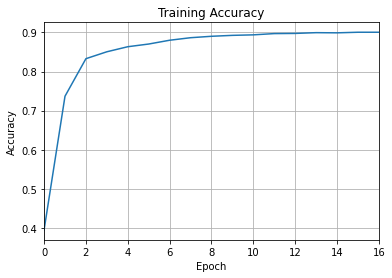

Test_accuracy 0.8105081826012058
Train with following parameters: out_channels: 46 kernel_size: 17  drop out: 0.46888114913744255 epochs: 17 batch_size: 49
Learn rate: 0.00011740616642569329
Epoch: 1; Accuracy: 0.4282332687755541
Epoch: 2; Accuracy: 0.6965784377017431
Epoch: 3; Accuracy: 0.7271357865289434
Epoch: 4; Accuracy: 0.7325156014633096
Epoch: 5; Accuracy: 0.7355282978265547
Epoch: 6; Accuracy: 0.7374650312029266
Epoch: 7; Accuracy: 0.7374650312029266
Epoch: 8; Accuracy: 0.7389713793845492
Epoch: 9; Accuracy: 0.7391865719819238
Epoch: 10; Accuracy: 0.7398321497740478
Epoch: 11; Accuracy: 0.7406929201635464
Epoch: 12; Accuracy: 0.7406929201635464
Epoch: 13; Accuracy: 0.7411233053582956
Epoch: 14; Accuracy: 0.7411233053582956
Epoch: 15; Accuracy: 0.7421992683451689
Epoch: 16; Accuracy: 0.741553690553045
Epoch: 17; Accuracy: 0.7424144609425436


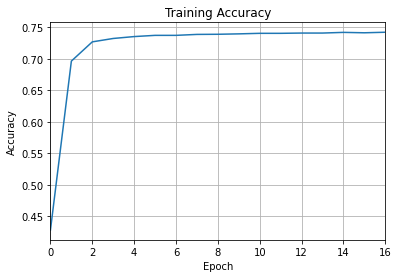

Test_accuracy 0.6968130921619293
Train with following parameters: out_channels: 46 kernel_size: 17  drop out: 0.46888114913744255 epochs: 17 batch_size: 49
Learn rate: 0.00011740616642569329
Epoch: 1; Accuracy: 0.3561437486550463
Epoch: 2; Accuracy: 0.6569829997848075
Epoch: 3; Accuracy: 0.8037443511943189
Epoch: 4; Accuracy: 0.8263395739186572
Epoch: 5; Accuracy: 0.842479018721756
Epoch: 6; Accuracy: 0.8536690337852378
Epoch: 7; Accuracy: 0.8601248117064773
Epoch: 8; Accuracy: 0.8614159672907252
Epoch: 9; Accuracy: 0.8659350118355928
Epoch: 10; Accuracy: 0.868302130406714
Epoch: 11; Accuracy: 0.8723907897568324
Epoch: 12; Accuracy: 0.8736819453410802
Epoch: 13; Accuracy: 0.8762642565095761
Epoch: 14; Accuracy: 0.8799225306649451
Epoch: 15; Accuracy: 0.8807833010544437
Epoch: 16; Accuracy: 0.8805681084570691
Epoch: 17; Accuracy: 0.8807833010544437


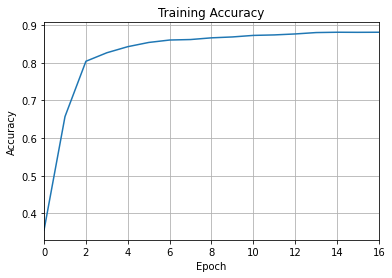

Test_accuracy 0.8975021533161068
Train with following parameters: out_channels: 46 kernel_size: 17  drop out: 0.46888114913744255 epochs: 17 batch_size: 49
Learn rate: 0.00011740616642569329
Epoch: 1; Accuracy: 0.42457499462018505
Epoch: 2; Accuracy: 0.6791478373143964
Epoch: 3; Accuracy: 0.7168065418549602
Epoch: 4; Accuracy: 0.7256294383473209
Epoch: 5; Accuracy: 0.7314396384764364
Epoch: 6; Accuracy: 0.7363890682160533
Epoch: 7; Accuracy: 0.7383258015924252
Epoch: 8; Accuracy: 0.7389713793845492
Epoch: 9; Accuracy: 0.7391865719819238
Epoch: 10; Accuracy: 0.7398321497740478
Epoch: 11; Accuracy: 0.7404777275661717
Epoch: 12; Accuracy: 0.7413384979556703
Epoch: 13; Accuracy: 0.7406929201635464
Epoch: 14; Accuracy: 0.7417688831504197
Epoch: 15; Accuracy: 0.7413384979556703
Epoch: 16; Accuracy: 0.7417688831504197
Epoch: 17; Accuracy: 0.7419840757477942


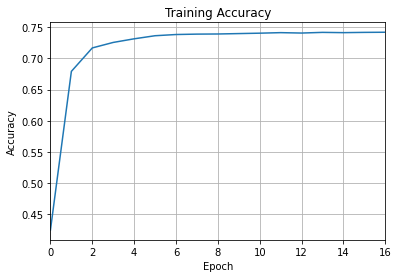

[INFO 02-06 17:04:43] ax.service.managed_loop: Running optimization trial 15...


Test_accuracy 0.719207579672696
Test_accuracy mean value 0.791386735572782


<ipython-input-8-38ab6afc99ca>:18: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



Train with following parameters: out_channels: 96 kernel_size: 17  drop out: 0.5940523525518683 epochs: 19 batch_size: 72
Learn rate: 3.181356850253103e-05
Epoch: 1; Accuracy: 0.2948138584032709
Epoch: 2; Accuracy: 0.4639552399397461
Epoch: 3; Accuracy: 0.6171723692704971
Epoch: 4; Accuracy: 0.7682375726275016
Epoch: 5; Accuracy: 0.8164407144394232
Epoch: 6; Accuracy: 0.828921885087153
Epoch: 7; Accuracy: 0.837529588982139
Epoch: 8; Accuracy: 0.8452765224876264
Epoch: 9; Accuracy: 0.8480740262534969
Epoch: 10; Accuracy: 0.8538842263826124
Epoch: 11; Accuracy: 0.8601248117064773
Epoch: 12; Accuracy: 0.863352700667097
Epoch: 13; Accuracy: 0.8678717452119648
Epoch: 14; Accuracy: 0.8710996341725845
Epoch: 15; Accuracy: 0.8736819453410802
Epoch: 16; Accuracy: 0.8749731009253282
Epoch: 17; Accuracy: 0.8773402194964494
Epoch: 18; Accuracy: 0.8788465676780719
Epoch: 19; Accuracy: 0.8807833010544437


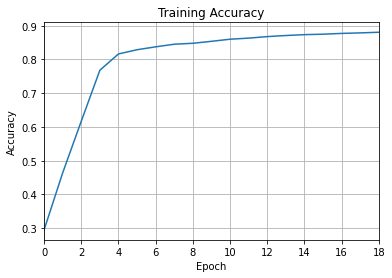

Test_accuracy 0.8535745047372955
Train with following parameters: out_channels: 96 kernel_size: 17  drop out: 0.5940523525518683 epochs: 19 batch_size: 72
Learn rate: 3.181356850253103e-05
Epoch: 1; Accuracy: 0.34409296320206584
Epoch: 2; Accuracy: 0.45319561007101355
Epoch: 3; Accuracy: 0.6016785022595222
Epoch: 4; Accuracy: 0.7159457714654616
Epoch: 5; Accuracy: 0.7409081127609211
Epoch: 6; Accuracy: 0.750161394448031
Epoch: 7; Accuracy: 0.7542500537981494
Epoch: 8; Accuracy: 0.7568323649666452
Epoch: 9; Accuracy: 0.7615666021088875
Epoch: 10; Accuracy: 0.7622121799010114
Epoch: 11; Accuracy: 0.7660856466537551
Epoch: 12; Accuracy: 0.7669464170432537
Epoch: 13; Accuracy: 0.7678071874327523
Epoch: 14; Accuracy: 0.7695287282117496
Epoch: 15; Accuracy: 0.7701743060038735
Epoch: 16; Accuracy: 0.7699591134064988
Epoch: 17; Accuracy: 0.77232623197762
Epoch: 18; Accuracy: 0.7721110393802453
Epoch: 19; Accuracy: 0.7721110393802453


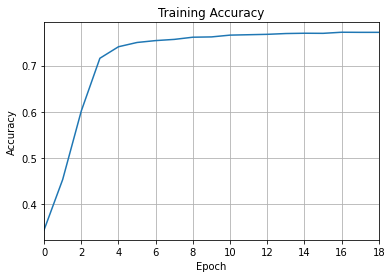

Test_accuracy 0.7071490094745909
Train with following parameters: out_channels: 96 kernel_size: 17  drop out: 0.5940523525518683 epochs: 19 batch_size: 72
Learn rate: 3.181356850253103e-05
Epoch: 1; Accuracy: 0.3204217774908543
Epoch: 2; Accuracy: 0.40735958683021306
Epoch: 3; Accuracy: 0.5633742199268346
Epoch: 4; Accuracy: 0.7314396384764364
Epoch: 5; Accuracy: 0.7777060469119862
Epoch: 6; Accuracy: 0.8252636109317839
Epoch: 7; Accuracy: 0.8435549817086292
Epoch: 8; Accuracy: 0.8493651818377448
Epoch: 9; Accuracy: 0.8592640413169786
Epoch: 10; Accuracy: 0.868302130406714
Epoch: 11; Accuracy: 0.8700236711857112
Epoch: 12; Accuracy: 0.8743275231332042
Epoch: 13; Accuracy: 0.8775554120938239
Epoch: 14; Accuracy: 0.878200989885948
Epoch: 15; Accuracy: 0.8822896492360662
Epoch: 16; Accuracy: 0.8814288788465677
Epoch: 17; Accuracy: 0.8857327307940607
Epoch: 18; Accuracy: 0.8848719604045621
Epoch: 19; Accuracy: 0.8874542715730579


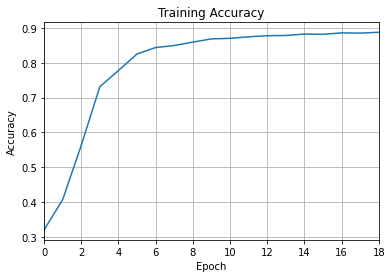

Test_accuracy 0.8397932816537468
Train with following parameters: out_channels: 96 kernel_size: 17  drop out: 0.5940523525518683 epochs: 19 batch_size: 72
Learn rate: 3.181356850253103e-05
Epoch: 1; Accuracy: 0.3053582956746288
Epoch: 2; Accuracy: 0.45190445448676564
Epoch: 3; Accuracy: 0.6206154508284915
Epoch: 4; Accuracy: 0.7075532601678503
Epoch: 5; Accuracy: 0.7441360017215408
Epoch: 6; Accuracy: 0.793845491715085
Epoch: 7; Accuracy: 0.8192382182052937
Epoch: 8; Accuracy: 0.8267699591134064
Epoch: 9; Accuracy: 0.8323649666451474
Epoch: 10; Accuracy: 0.8390359371637616
Epoch: 11; Accuracy: 0.8435549817086292
Epoch: 12; Accuracy: 0.8519474930062406
Epoch: 13; Accuracy: 0.8538842263826124
Epoch: 14; Accuracy: 0.8577576931353561
Epoch: 15; Accuracy: 0.8631375080697224
Epoch: 16; Accuracy: 0.8678717452119648
Epoch: 17; Accuracy: 0.8680869378093393
Epoch: 18; Accuracy: 0.8728211749515816
Epoch: 19; Accuracy: 0.8756186787174521


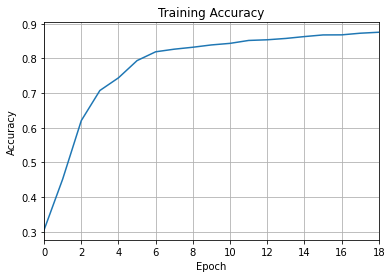

Test_accuracy 0.8880275624461671
Train with following parameters: out_channels: 96 kernel_size: 17  drop out: 0.5940523525518683 epochs: 19 batch_size: 72
Learn rate: 3.181356850253103e-05
Epoch: 1; Accuracy: 0.29395308801377235
Epoch: 2; Accuracy: 0.4643856251344954
Epoch: 3; Accuracy: 0.6335270066709705
Epoch: 4; Accuracy: 0.7746933505487411
Epoch: 5; Accuracy: 0.802453195610071
Epoch: 6; Accuracy: 0.8224661071659135
Epoch: 7; Accuracy: 0.8297826554766516
Epoch: 8; Accuracy: 0.8416182483322574
Epoch: 9; Accuracy: 0.8465676780718743
Epoch: 10; Accuracy: 0.8506563374219926
Epoch: 11; Accuracy: 0.8584032709274801
Epoch: 12; Accuracy: 0.8631375080697224
Epoch: 13; Accuracy: 0.8661502044329675
Epoch: 14; Accuracy: 0.8678717452119648
Epoch: 15; Accuracy: 0.868302130406714
Epoch: 16; Accuracy: 0.8721755971594577
Epoch: 17; Accuracy: 0.8754034861200775
Epoch: 18; Accuracy: 0.8771250268990747
Epoch: 19; Accuracy: 0.8794921454701958


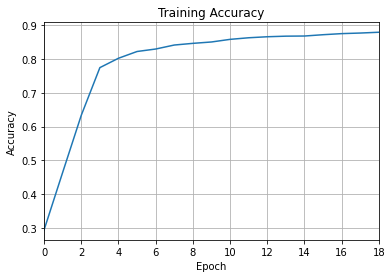

[INFO 02-06 17:08:14] ax.service.managed_loop: Running optimization trial 16...


Test_accuracy 0.8570198105081827
Test_accuracy mean value 0.8291128337639966


<ipython-input-8-38ab6afc99ca>:18: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



Train with following parameters: out_channels: 113 kernel_size: 17  drop out: 0.4717026913562901 epochs: 19 batch_size: 50
Learn rate: 6.381211989361776e-05
Epoch: 1; Accuracy: 0.42156229825693997
Epoch: 2; Accuracy: 0.7880352915859694
Epoch: 3; Accuracy: 0.8278459221002797
Epoch: 4; Accuracy: 0.8448461372928772
Epoch: 5; Accuracy: 0.8573273079406069
Epoch: 6; Accuracy: 0.8667957822250915
Epoch: 7; Accuracy: 0.8702388637830859
Epoch: 8; Accuracy: 0.8786313750806972
Epoch: 9; Accuracy: 0.8799225306649451
Epoch: 10; Accuracy: 0.881859264041317
Epoch: 11; Accuracy: 0.8846567678071874
Epoch: 12; Accuracy: 0.8846567678071874
Epoch: 13; Accuracy: 0.8870238863783085
Epoch: 14; Accuracy: 0.8887454271573058
Epoch: 15; Accuracy: 0.8885302345599312
Epoch: 16; Accuracy: 0.8876694641704326
Epoch: 17; Accuracy: 0.8900365827415537
Epoch: 18; Accuracy: 0.8900365827415537
Epoch: 19; Accuracy: 0.8908973531310523


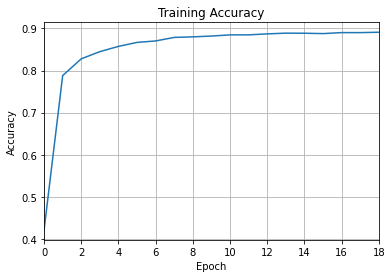

Test_accuracy 0.8466838931955211
Train with following parameters: out_channels: 113 kernel_size: 17  drop out: 0.4717026913562901 epochs: 19 batch_size: 50
Learn rate: 6.381211989361776e-05
Epoch: 1; Accuracy: 0.4816010329244674
Epoch: 2; Accuracy: 0.8086937809339358
Epoch: 3; Accuracy: 0.8414030557348827
Epoch: 4; Accuracy: 0.859694426511728
Epoch: 5; Accuracy: 0.8741123305358296
Epoch: 6; Accuracy: 0.8790617602754466
Epoch: 7; Accuracy: 0.8825048418334409
Epoch: 8; Accuracy: 0.8891758123520551
Epoch: 9; Accuracy: 0.8913277383258016
Epoch: 10; Accuracy: 0.8956315902732946
Epoch: 11; Accuracy: 0.8967075532601678
Epoch: 12; Accuracy: 0.8982139014417904
Epoch: 13; Accuracy: 0.898429094039165
Epoch: 14; Accuracy: 0.898429094039165
Epoch: 15; Accuracy: 0.9005810200129115
Epoch: 16; Accuracy: 0.9014417904024101
Epoch: 17; Accuracy: 0.9014417904024101
Epoch: 18; Accuracy: 0.9025177533892834
Epoch: 19; Accuracy: 0.9023025607919087


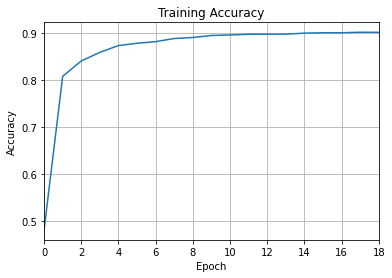

Test_accuracy 0.788975021533161
Train with following parameters: out_channels: 113 kernel_size: 17  drop out: 0.4717026913562901 epochs: 19 batch_size: 50
Learn rate: 6.381211989361776e-05
Epoch: 1; Accuracy: 0.43856251344953734
Epoch: 2; Accuracy: 0.6632235851086723
Epoch: 3; Accuracy: 0.7837314396384765
Epoch: 4; Accuracy: 0.8474284484613729
Epoch: 5; Accuracy: 0.8637830858618464
Epoch: 6; Accuracy: 0.872605982354207
Epoch: 7; Accuracy: 0.8805681084570691
Epoch: 8; Accuracy: 0.8829352270281903
Epoch: 9; Accuracy: 0.885517538196686
Epoch: 10; Accuracy: 0.8878846567678071
Epoch: 11; Accuracy: 0.8883150419625565
Epoch: 12; Accuracy: 0.890466967936303
Epoch: 13; Accuracy: 0.8913277383258016
Epoch: 14; Accuracy: 0.8919733161179255
Epoch: 15; Accuracy: 0.8919733161179255
Epoch: 16; Accuracy: 0.8941252420916721
Epoch: 17; Accuracy: 0.8943404346890467
Epoch: 18; Accuracy: 0.8943404346890467
Epoch: 19; Accuracy: 0.8956315902732946


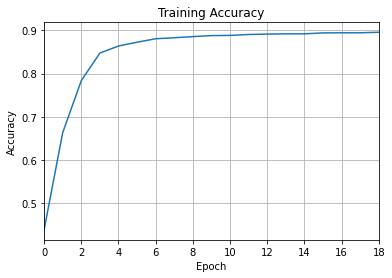

Test_accuracy 0.8329026701119724
Train with following parameters: out_channels: 113 kernel_size: 17  drop out: 0.4717026913562901 epochs: 19 batch_size: 50
Learn rate: 6.381211989361776e-05
Epoch: 1; Accuracy: 0.4183344092963202
Epoch: 2; Accuracy: 0.7411233053582956
Epoch: 3; Accuracy: 0.8237572627501614
Epoch: 4; Accuracy: 0.838175166774263
Epoch: 5; Accuracy: 0.8480740262534969
Epoch: 6; Accuracy: 0.8581880783301055
Epoch: 7; Accuracy: 0.8657198192382182
Epoch: 8; Accuracy: 0.8695932859909619
Epoch: 9; Accuracy: 0.8771250268990747
Epoch: 10; Accuracy: 0.8831504196255648
Epoch: 11; Accuracy: 0.8848719604045621
Epoch: 12; Accuracy: 0.8859479233914354
Epoch: 13; Accuracy: 0.8872390789756832
Epoch: 14; Accuracy: 0.8876694641704326
Epoch: 15; Accuracy: 0.8885302345599312
Epoch: 16; Accuracy: 0.8896061975468044
Epoch: 17; Accuracy: 0.8911125457284269
Epoch: 18; Accuracy: 0.8913277383258016
Epoch: 19; Accuracy: 0.8908973531310523


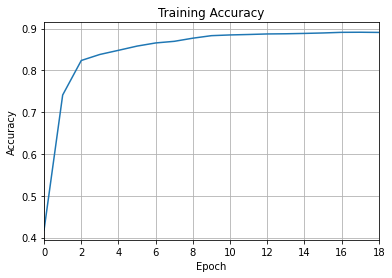

Test_accuracy 0.8957795004306632
Train with following parameters: out_channels: 113 kernel_size: 17  drop out: 0.4717026913562901 epochs: 19 batch_size: 50
Learn rate: 6.381211989361776e-05
Epoch: 1; Accuracy: 0.3804605121583817
Epoch: 2; Accuracy: 0.6737680223800301
Epoch: 3; Accuracy: 0.7394017645792985
Epoch: 4; Accuracy: 0.7497310092532817
Epoch: 5; Accuracy: 0.758123520550893
Epoch: 6; Accuracy: 0.7639337206800086
Epoch: 7; Accuracy: 0.7650096836668818
Epoch: 8; Accuracy: 0.7656552614590059
Epoch: 9; Accuracy: 0.7656552614590059
Epoch: 10; Accuracy: 0.766731224445879
Epoch: 11; Accuracy: 0.766731224445879
Epoch: 12; Accuracy: 0.7669464170432537
Epoch: 13; Accuracy: 0.7675919948353777
Epoch: 14; Accuracy: 0.7684527652248763
Epoch: 15; Accuracy: 0.7682375726275016
Epoch: 16; Accuracy: 0.7682375726275016
Epoch: 17; Accuracy: 0.7688831504196255
Epoch: 18; Accuracy: 0.7695287282117496
Epoch: 19; Accuracy: 0.7684527652248763


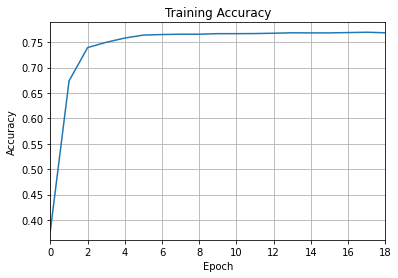

[INFO 02-06 17:12:36] ax.service.managed_loop: Running optimization trial 17...


Test_accuracy 0.7459086993970715
Test_accuracy mean value 0.8220499569336779


<ipython-input-8-38ab6afc99ca>:18: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



Train with following parameters: out_channels: 65 kernel_size: 14  drop out: 0.3932242052214551 epochs: 19 batch_size: 61
Learn rate: 9.063562191211168e-05
Epoch: 1; Accuracy: 0.38132128254788034
Epoch: 2; Accuracy: 0.6257800731654831
Epoch: 3; Accuracy: 0.7413384979556703
Epoch: 4; Accuracy: 0.7538196686034
Epoch: 5; Accuracy: 0.7568323649666452
Epoch: 6; Accuracy: 0.7604906391220142
Epoch: 7; Accuracy: 0.7617817947062621
Epoch: 8; Accuracy: 0.7615666021088875
Epoch: 9; Accuracy: 0.76307295029051
Epoch: 10; Accuracy: 0.7643641058747579
Epoch: 11; Accuracy: 0.7654400688616312
Epoch: 12; Accuracy: 0.7663008392511298
Epoch: 13; Accuracy: 0.7675919948353777
Epoch: 14; Accuracy: 0.768022380030127
Epoch: 15; Accuracy: 0.768022380030127
Epoch: 16; Accuracy: 0.7678071874327523
Epoch: 17; Accuracy: 0.7684527652248763
Epoch: 18; Accuracy: 0.7695287282117496
Epoch: 19; Accuracy: 0.7693135356143749


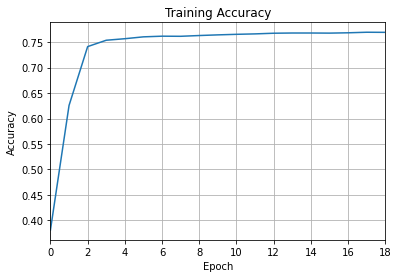

Test_accuracy 0.7338501291989664
Train with following parameters: out_channels: 65 kernel_size: 14  drop out: 0.3932242052214551 epochs: 19 batch_size: 61
Learn rate: 9.063562191211168e-05
Epoch: 1; Accuracy: 0.3768022380030127
Epoch: 2; Accuracy: 0.7718958467828707
Epoch: 3; Accuracy: 0.8218205293737896
Epoch: 4; Accuracy: 0.8446309446955025
Epoch: 5; Accuracy: 0.8616311598880998
Epoch: 6; Accuracy: 0.8680869378093393
Epoch: 7; Accuracy: 0.8749731009253282
Epoch: 8; Accuracy: 0.8794921454701958
Epoch: 9; Accuracy: 0.8827200344308156
Epoch: 10; Accuracy: 0.8842263826124381
Epoch: 11; Accuracy: 0.8883150419625565
Epoch: 12; Accuracy: 0.8906821605336777
Epoch: 13; Accuracy: 0.8928340865074241
Epoch: 14; Accuracy: 0.8949860124811706
Epoch: 15; Accuracy: 0.8958467828706692
Epoch: 16; Accuracy: 0.8962771680654186
Epoch: 17; Accuracy: 0.8967075532601678
Epoch: 18; Accuracy: 0.8977835162470411
Epoch: 19; Accuracy: 0.8982139014417904


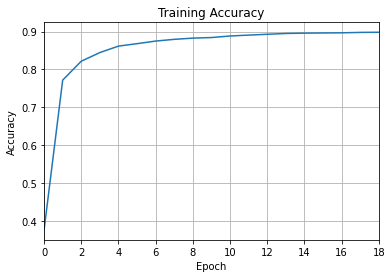

Test_accuracy 0.8105081826012058
Train with following parameters: out_channels: 65 kernel_size: 14  drop out: 0.3932242052214551 epochs: 19 batch_size: 61
Learn rate: 9.063562191211168e-05
Epoch: 1; Accuracy: 0.34538411878631375
Epoch: 2; Accuracy: 0.6386916290079622
Epoch: 3; Accuracy: 0.7891112545728427
Epoch: 4; Accuracy: 0.8396815149558855
Epoch: 5; Accuracy: 0.8528082633957392
Epoch: 6; Accuracy: 0.8622767376802238
Epoch: 7; Accuracy: 0.8708844415752098
Epoch: 8; Accuracy: 0.8831504196255648
Epoch: 9; Accuracy: 0.88616311598881
Epoch: 10; Accuracy: 0.8865935011835593
Epoch: 11; Accuracy: 0.8902517753389283
Epoch: 12; Accuracy: 0.8924037013126749
Epoch: 13; Accuracy: 0.8919733161179255
Epoch: 14; Accuracy: 0.894770819883796
Epoch: 15; Accuracy: 0.8958467828706692
Epoch: 16; Accuracy: 0.8962771680654186
Epoch: 17; Accuracy: 0.8967075532601678
Epoch: 18; Accuracy: 0.8964923606627933
Epoch: 19; Accuracy: 0.8977835162470411


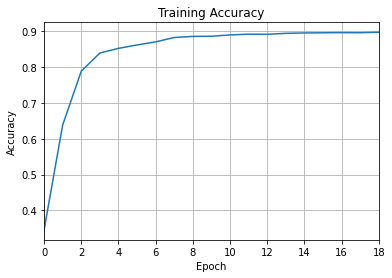

Test_accuracy 0.834625322997416
Train with following parameters: out_channels: 65 kernel_size: 14  drop out: 0.3932242052214551 epochs: 19 batch_size: 61
Learn rate: 9.063562191211168e-05
Epoch: 1; Accuracy: 0.398751882935227
Epoch: 2; Accuracy: 0.7523133204217775
Epoch: 3; Accuracy: 0.8106305143103077
Epoch: 4; Accuracy: 0.8302130406714009
Epoch: 5; Accuracy: 0.8388207445663869
Epoch: 6; Accuracy: 0.8469980632666236
Epoch: 7; Accuracy: 0.8573273079406069
Epoch: 8; Accuracy: 0.8605551969012266
Epoch: 9; Accuracy: 0.863998278459221
Epoch: 10; Accuracy: 0.8672261674198407
Epoch: 11; Accuracy: 0.872605982354207
Epoch: 12; Accuracy: 0.8760490639122014
Epoch: 13; Accuracy: 0.8801377232623198
Epoch: 14; Accuracy: 0.8807833010544437
Epoch: 15; Accuracy: 0.8820744566386917
Epoch: 16; Accuracy: 0.8827200344308156
Epoch: 17; Accuracy: 0.8840111900150635
Epoch: 18; Accuracy: 0.885517538196686
Epoch: 19; Accuracy: 0.8859479233914354


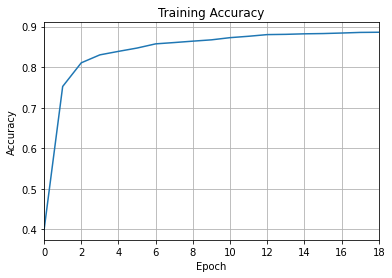

Test_accuracy 0.9026701119724375
Train with following parameters: out_channels: 65 kernel_size: 14  drop out: 0.3932242052214551 epochs: 19 batch_size: 61
Learn rate: 9.063562191211168e-05
Epoch: 1; Accuracy: 0.35851086722616743
Epoch: 2; Accuracy: 0.635033354852593
Epoch: 3; Accuracy: 0.776630083925113
Epoch: 4; Accuracy: 0.8188078330105444
Epoch: 5; Accuracy: 0.834516892618894
Epoch: 6; Accuracy: 0.8493651818377448
Epoch: 7; Accuracy: 0.8573273079406069
Epoch: 8; Accuracy: 0.8667957822250915
Epoch: 9; Accuracy: 0.8691629007962126
Epoch: 10; Accuracy: 0.8747579083279535
Epoch: 11; Accuracy: 0.8769098343017
Epoch: 12; Accuracy: 0.8842263826124381
Epoch: 13; Accuracy: 0.8842263826124381
Epoch: 14; Accuracy: 0.8859479233914354
Epoch: 15; Accuracy: 0.8889606197546804
Epoch: 16; Accuracy: 0.8896061975468044
Epoch: 17; Accuracy: 0.8902517753389283
Epoch: 18; Accuracy: 0.8908973531310523
Epoch: 19; Accuracy: 0.8921885087153002


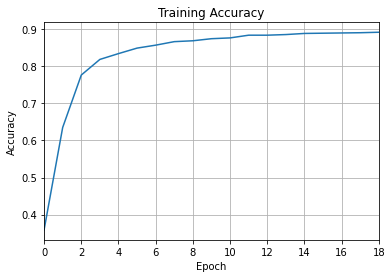

[INFO 02-06 17:15:22] ax.service.managed_loop: Running optimization trial 18...


Test_accuracy 0.8647717484926787
Test_accuracy mean value 0.8292850990525409


<ipython-input-8-38ab6afc99ca>:18: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



Train with following parameters: out_channels: 76 kernel_size: 16  drop out: 0.6028869918594366 epochs: 20 batch_size: 59
Learn rate: 0.0001983089337032056
Epoch: 1; Accuracy: 0.5147406929201636
Epoch: 2; Accuracy: 0.8076178179470627
Epoch: 3; Accuracy: 0.8431245965138799
Epoch: 4; Accuracy: 0.8648590488487196
Epoch: 5; Accuracy: 0.8758338713148268
Epoch: 6; Accuracy: 0.8859479233914354
Epoch: 7; Accuracy: 0.8926188939100494
Epoch: 8; Accuracy: 0.8936948568969227
Epoch: 9; Accuracy: 0.8979987088444158
Epoch: 10; Accuracy: 0.9005810200129115
Epoch: 11; Accuracy: 0.9020873681945341
Epoch: 12; Accuracy: 0.904024101570906
Epoch: 13; Accuracy: 0.904024101570906
Epoch: 14; Accuracy: 0.9046696793630299
Epoch: 15; Accuracy: 0.9038089089735313
Epoch: 16; Accuracy: 0.9059608349472779
Epoch: 17; Accuracy: 0.9068216053367764
Epoch: 18; Accuracy: 0.9081127609210243
Epoch: 19; Accuracy: 0.9063912201420271
Epoch: 20; Accuracy: 0.9096191091026469


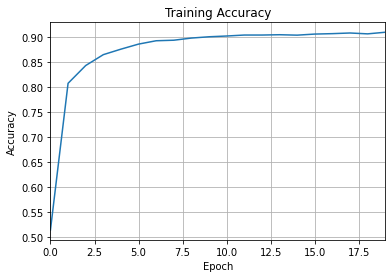

Test_accuracy 0.8329026701119724
Train with following parameters: out_channels: 76 kernel_size: 16  drop out: 0.6028869918594366 epochs: 20 batch_size: 59
Learn rate: 0.0001983089337032056
Epoch: 1; Accuracy: 0.5104368409726705
Epoch: 2; Accuracy: 0.7525285130191521
Epoch: 3; Accuracy: 0.7658704540563804
Epoch: 4; Accuracy: 0.7660856466537551
Epoch: 5; Accuracy: 0.7701743060038735
Epoch: 6; Accuracy: 0.7708198837959974
Epoch: 7; Accuracy: 0.7721110393802453
Epoch: 8; Accuracy: 0.7746933505487411
Epoch: 9; Accuracy: 0.7744781579513664
Epoch: 10; Accuracy: 0.775338928340865
Epoch: 11; Accuracy: 0.7757693135356144
Epoch: 12; Accuracy: 0.7783516247041101
Epoch: 13; Accuracy: 0.7796427802883581
Epoch: 14; Accuracy: 0.7781364321067356
Epoch: 15; Accuracy: 0.7794275876909834
Epoch: 16; Accuracy: 0.7796427802883581
Epoch: 17; Accuracy: 0.7807187432752314
Epoch: 18; Accuracy: 0.7817947062621046
Epoch: 19; Accuracy: 0.8018076178179471
Epoch: 20; Accuracy: 0.8702388637830859


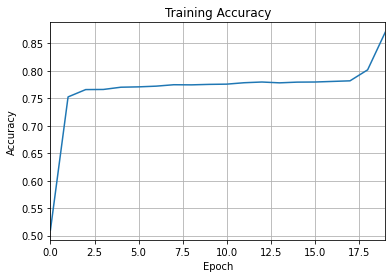

Test_accuracy 0.7459086993970715
Train with following parameters: out_channels: 76 kernel_size: 16  drop out: 0.6028869918594366 epochs: 20 batch_size: 59
Learn rate: 0.0001983089337032056
Epoch: 1; Accuracy: 0.5754250053798149
Epoch: 2; Accuracy: 0.8224661071659135
Epoch: 3; Accuracy: 0.8495803744351195
Epoch: 4; Accuracy: 0.8637830858618464
Epoch: 5; Accuracy: 0.8790617602754466
Epoch: 6; Accuracy: 0.8837959974176889
Epoch: 7; Accuracy: 0.8889606197546804
Epoch: 8; Accuracy: 0.8908973531310523
Epoch: 9; Accuracy: 0.8917581235205508
Epoch: 10; Accuracy: 0.8943404346890467
Epoch: 11; Accuracy: 0.8958467828706692
Epoch: 12; Accuracy: 0.8969227458575425
Epoch: 13; Accuracy: 0.8982139014417904
Epoch: 14; Accuracy: 0.8979987088444158
Epoch: 15; Accuracy: 0.899074671831289
Epoch: 16; Accuracy: 0.900365827415537
Epoch: 17; Accuracy: 0.899074671831289
Epoch: 18; Accuracy: 0.9005810200129115
Epoch: 19; Accuracy: 0.9001506348181623
Epoch: 20; Accuracy: 0.9005810200129115


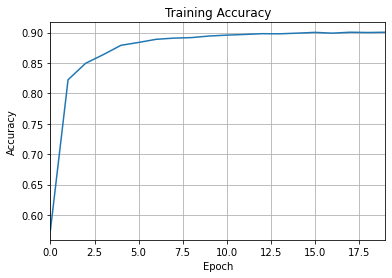

Test_accuracy 0.830318690783807
Train with following parameters: out_channels: 76 kernel_size: 16  drop out: 0.6028869918594366 epochs: 20 batch_size: 59
Learn rate: 0.0001983089337032056
Epoch: 1; Accuracy: 0.4854744996772111
Epoch: 2; Accuracy: 0.7994404992468259
Epoch: 3; Accuracy: 0.8312890036582742
Epoch: 4; Accuracy: 0.8500107596298687
Epoch: 5; Accuracy: 0.8620615450828492
Epoch: 6; Accuracy: 0.8627071228749731
Epoch: 7; Accuracy: 0.8704540563804605
Epoch: 8; Accuracy: 0.8736819453410802
Epoch: 9; Accuracy: 0.8751882935227028
Epoch: 10; Accuracy: 0.8766946417043253
Epoch: 11; Accuracy: 0.8779857972885733
Epoch: 12; Accuracy: 0.8786313750806972
Epoch: 13; Accuracy: 0.8801377232623198
Epoch: 14; Accuracy: 0.8807833010544437
Epoch: 15; Accuracy: 0.8797073380675705
Epoch: 16; Accuracy: 0.881859264041317
Epoch: 17; Accuracy: 0.8829352270281903
Epoch: 18; Accuracy: 0.8829352270281903
Epoch: 19; Accuracy: 0.8853023455993114
Epoch: 20; Accuracy: 0.8848719604045621


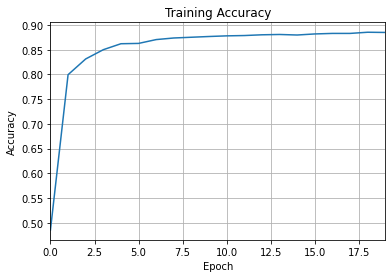

Test_accuracy 0.9009474590869939
Train with following parameters: out_channels: 76 kernel_size: 16  drop out: 0.6028869918594366 epochs: 20 batch_size: 59
Learn rate: 0.0001983089337032056
Epoch: 1; Accuracy: 0.5044114482461803
Epoch: 2; Accuracy: 0.7318700236711857
Epoch: 3; Accuracy: 0.7525285130191521
Epoch: 4; Accuracy: 0.7624273724983861
Epoch: 5; Accuracy: 0.7641489132773832
Epoch: 6; Accuracy: 0.7658704540563804
Epoch: 7; Accuracy: 0.767376802238003
Epoch: 8; Accuracy: 0.7671616096406284
Epoch: 9; Accuracy: 0.7684527652248763
Epoch: 10; Accuracy: 0.7684527652248763
Epoch: 11; Accuracy: 0.768667957822251
Epoch: 12; Accuracy: 0.7682375726275016
Epoch: 13; Accuracy: 0.768022380030127
Epoch: 14; Accuracy: 0.7684527652248763
Epoch: 15; Accuracy: 0.768667957822251
Epoch: 16; Accuracy: 0.7697439208091241
Epoch: 17; Accuracy: 0.7695287282117496
Epoch: 18; Accuracy: 0.7697439208091241
Epoch: 19; Accuracy: 0.7703894986012482
Epoch: 20; Accuracy: 0.7693135356143749


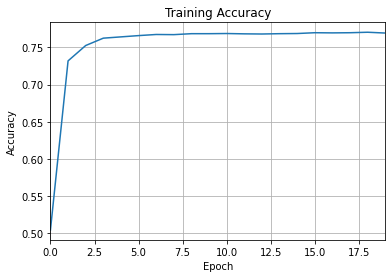

[INFO 02-06 17:18:37] ax.service.managed_loop: Running optimization trial 19...


Test_accuracy 0.751937984496124
Test_accuracy mean value 0.8124031007751938


<ipython-input-8-38ab6afc99ca>:18: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



Train with following parameters: out_channels: 92 kernel_size: 15  drop out: 0.5310193778296093 epochs: 17 batch_size: 66
Learn rate: 0.00013025852104930655
Epoch: 1; Accuracy: 0.42909403916505273
Epoch: 2; Accuracy: 0.7779212395093609
Epoch: 3; Accuracy: 0.8347320852162685
Epoch: 4; Accuracy: 0.8577576931353561
Epoch: 5; Accuracy: 0.8734667527437057
Epoch: 6; Accuracy: 0.8814288788465677
Epoch: 7; Accuracy: 0.8900365827415537
Epoch: 8; Accuracy: 0.8921885087153002
Epoch: 9; Accuracy: 0.8952012050785453
Epoch: 10; Accuracy: 0.8969227458575425
Epoch: 11; Accuracy: 0.899074671831289
Epoch: 12; Accuracy: 0.9007962126102862
Epoch: 13; Accuracy: 0.9020873681945341
Epoch: 14; Accuracy: 0.9007962126102862
Epoch: 15; Accuracy: 0.9038089089735313
Epoch: 16; Accuracy: 0.9027329459866581
Epoch: 17; Accuracy: 0.9053152571551538


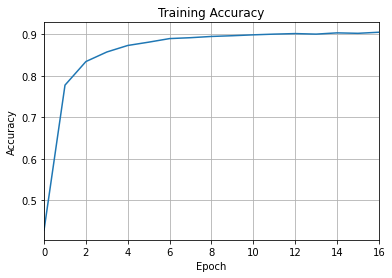

Test_accuracy 0.8475452196382429
Train with following parameters: out_channels: 92 kernel_size: 15  drop out: 0.5310193778296093 epochs: 17 batch_size: 66
Learn rate: 0.00013025852104930655
Epoch: 1; Accuracy: 0.49472778136432105
Epoch: 2; Accuracy: 0.71078114912847
Epoch: 3; Accuracy: 0.7314396384764364
Epoch: 4; Accuracy: 0.7447815795136647
Epoch: 5; Accuracy: 0.7488702388637831
Epoch: 6; Accuracy: 0.7518829352270282
Epoch: 7; Accuracy: 0.755110824187648
Epoch: 8; Accuracy: 0.7576931353561438
Epoch: 9; Accuracy: 0.7615666021088875
Epoch: 10; Accuracy: 0.763718528082634
Epoch: 11; Accuracy: 0.7643641058747579
Epoch: 12; Accuracy: 0.7654400688616312
Epoch: 13; Accuracy: 0.7665160318485044
Epoch: 14; Accuracy: 0.7669464170432537
Epoch: 15; Accuracy: 0.768022380030127
Epoch: 16; Accuracy: 0.7675919948353777
Epoch: 17; Accuracy: 0.7701743060038735


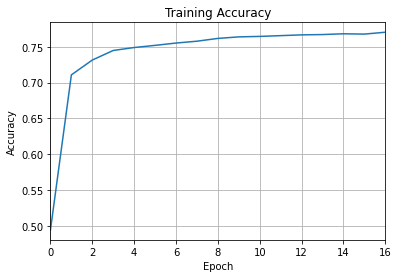

Test_accuracy 0.6890611541774333
Train with following parameters: out_channels: 92 kernel_size: 15  drop out: 0.5310193778296093 epochs: 17 batch_size: 66
Learn rate: 0.00013025852104930655
Epoch: 1; Accuracy: 0.4230686464385625
Epoch: 2; Accuracy: 0.7480094684742845
Epoch: 3; Accuracy: 0.8444157520981278
Epoch: 4; Accuracy: 0.8691629007962126
Epoch: 5; Accuracy: 0.8771250268990747
Epoch: 6; Accuracy: 0.8840111900150635
Epoch: 7; Accuracy: 0.8878846567678071
Epoch: 8; Accuracy: 0.8919733161179255
Epoch: 9; Accuracy: 0.8928340865074241
Epoch: 10; Accuracy: 0.8941252420916721
Epoch: 11; Accuracy: 0.8962771680654186
Epoch: 12; Accuracy: 0.8962771680654186
Epoch: 13; Accuracy: 0.8964923606627933
Epoch: 14; Accuracy: 0.8973531310522918
Epoch: 15; Accuracy: 0.8982139014417904
Epoch: 16; Accuracy: 0.8979987088444158
Epoch: 17; Accuracy: 0.8982139014417904


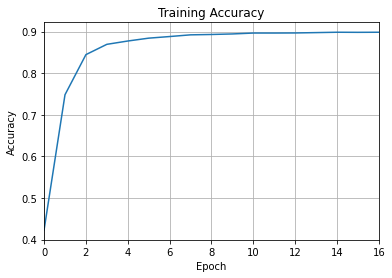

Test_accuracy 0.8415159345391904
Train with following parameters: out_channels: 92 kernel_size: 15  drop out: 0.5310193778296093 epochs: 17 batch_size: 66
Learn rate: 0.00013025852104930655
Epoch: 1; Accuracy: 0.4503981063051431
Epoch: 2; Accuracy: 0.7925543361308371
Epoch: 3; Accuracy: 0.8280611146976544
Epoch: 4; Accuracy: 0.8448461372928772
Epoch: 5; Accuracy: 0.8584032709274801
Epoch: 6; Accuracy: 0.868302130406714
Epoch: 7; Accuracy: 0.872605982354207
Epoch: 8; Accuracy: 0.8760490639122014
Epoch: 9; Accuracy: 0.8803529158596944
Epoch: 10; Accuracy: 0.8835808048203142
Epoch: 11; Accuracy: 0.8833656122229395
Epoch: 12; Accuracy: 0.8863783085861846
Epoch: 13; Accuracy: 0.886808693780934
Epoch: 14; Accuracy: 0.8878846567678071
Epoch: 15; Accuracy: 0.8887454271573058
Epoch: 16; Accuracy: 0.889821390144179
Epoch: 17; Accuracy: 0.8906821605336777


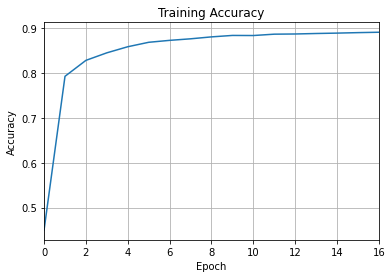

Test_accuracy 0.9018087855297158
Train with following parameters: out_channels: 92 kernel_size: 15  drop out: 0.5310193778296093 epochs: 17 batch_size: 66
Learn rate: 0.00013025852104930655
Epoch: 1; Accuracy: 0.48052506993759414
Epoch: 2; Accuracy: 0.7271357865289434
Epoch: 3; Accuracy: 0.7505917796427803
Epoch: 4; Accuracy: 0.7576931353561438
Epoch: 5; Accuracy: 0.7628577576931354
Epoch: 6; Accuracy: 0.7641489132773832
Epoch: 7; Accuracy: 0.7652248762642565
Epoch: 8; Accuracy: 0.7669464170432537
Epoch: 9; Accuracy: 0.7669464170432537
Epoch: 10; Accuracy: 0.7675919948353777
Epoch: 11; Accuracy: 0.766731224445879
Epoch: 12; Accuracy: 0.7682375726275016
Epoch: 13; Accuracy: 0.7684527652248763
Epoch: 14; Accuracy: 0.768667957822251
Epoch: 15; Accuracy: 0.7693135356143749
Epoch: 16; Accuracy: 0.7697439208091241
Epoch: 17; Accuracy: 0.7693135356143749


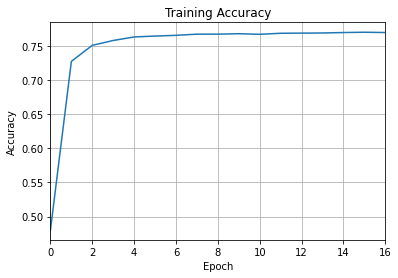

[INFO 02-06 17:21:49] ax.service.managed_loop: Running optimization trial 20...


Test_accuracy 0.7450473729543498
Test_accuracy mean value 0.8049956933677864


<ipython-input-8-38ab6afc99ca>:18: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



Train with following parameters: out_channels: 88 kernel_size: 17  drop out: 0.5549933474249789 epochs: 20 batch_size: 48
Learn rate: 9.520263469255729e-06
Epoch: 1; Accuracy: 0.25091456853884225
Epoch: 2; Accuracy: 0.3178394663223585
Epoch: 3; Accuracy: 0.40176457929847215
Epoch: 4; Accuracy: 0.5171078114912847
Epoch: 5; Accuracy: 0.5446524639552399
Epoch: 6; Accuracy: 0.5739186571981924
Epoch: 7; Accuracy: 0.6686034000430385
Epoch: 8; Accuracy: 0.7189584678287066
Epoch: 9; Accuracy: 0.724338282763073
Epoch: 10; Accuracy: 0.7286421347105659
Epoch: 11; Accuracy: 0.7299332902948139
Epoch: 12; Accuracy: 0.737895416397676
Epoch: 13; Accuracy: 0.7957822250914569
Epoch: 14; Accuracy: 0.8166559070367979
Epoch: 15; Accuracy: 0.8244028405422853
Epoch: 16; Accuracy: 0.8261243813212825
Epoch: 17; Accuracy: 0.8293522702819023
Epoch: 18; Accuracy: 0.8323649666451474
Epoch: 19; Accuracy: 0.8347320852162685
Epoch: 20; Accuracy: 0.8401119001506349


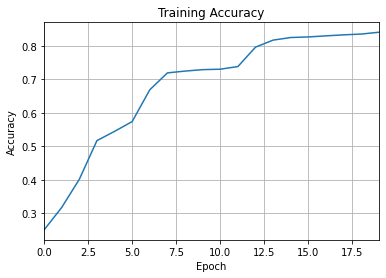

Test_accuracy 0.8285960378983634
Train with following parameters: out_channels: 88 kernel_size: 17  drop out: 0.5549933474249789 epochs: 20 batch_size: 48
Learn rate: 9.520263469255729e-06
Epoch: 1; Accuracy: 0.2300408865935012
Epoch: 2; Accuracy: 0.3298902517753389
Epoch: 3; Accuracy: 0.3981063051431031
Epoch: 4; Accuracy: 0.5173230040886594
Epoch: 5; Accuracy: 0.5954379169356574
Epoch: 6; Accuracy: 0.6395523993974608
Epoch: 7; Accuracy: 0.6522487626425651
Epoch: 8; Accuracy: 0.6709705186141597
Epoch: 9; Accuracy: 0.6933505487411233
Epoch: 10; Accuracy: 0.7398321497740478
Epoch: 11; Accuracy: 0.789541639767592
Epoch: 12; Accuracy: 0.8168710996341726
Epoch: 13; Accuracy: 0.8190230256079191
Epoch: 14; Accuracy: 0.8276307295029051
Epoch: 15; Accuracy: 0.8308586184635248
Epoch: 16; Accuracy: 0.8373143963847643
Epoch: 17; Accuracy: 0.8392511297611362
Epoch: 18; Accuracy: 0.8435549817086292
Epoch: 19; Accuracy: 0.8472132558639983
Epoch: 20; Accuracy: 0.8513019152141167


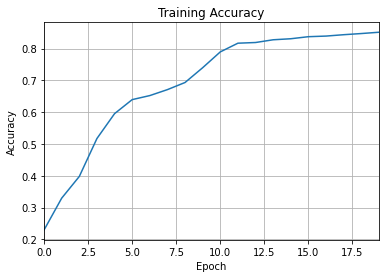

Test_accuracy 0.756244616709733
Train with following parameters: out_channels: 88 kernel_size: 17  drop out: 0.5549933474249789 epochs: 20 batch_size: 48
Learn rate: 9.520263469255729e-06
Epoch: 1; Accuracy: 0.31590273294598664
Epoch: 2; Accuracy: 0.3374219926834517
Epoch: 3; Accuracy: 0.42565095760705834
Epoch: 4; Accuracy: 0.5381966860340004
Epoch: 5; Accuracy: 0.5648805681084571
Epoch: 6; Accuracy: 0.579083279535184
Epoch: 7; Accuracy: 0.6330966214762213
Epoch: 8; Accuracy: 0.7000215192597374
Epoch: 9; Accuracy: 0.7307940606843124
Epoch: 10; Accuracy: 0.7514525500322788
Epoch: 11; Accuracy: 0.76307295029051
Epoch: 12; Accuracy: 0.8011620400258231
Epoch: 13; Accuracy: 0.8190230256079191
Epoch: 14; Accuracy: 0.828921885087153
Epoch: 15; Accuracy: 0.8351624704110179
Epoch: 16; Accuracy: 0.8409726705401335
Epoch: 17; Accuracy: 0.8429094039165053
Epoch: 18; Accuracy: 0.8482892188508715
Epoch: 19; Accuracy: 0.8506563374219926
Epoch: 20; Accuracy: 0.8528082633957392


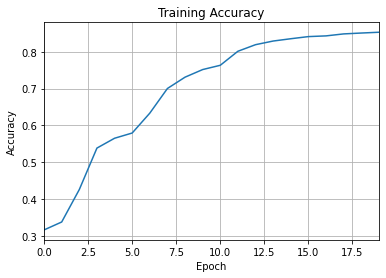

Test_accuracy 0.7958656330749354
Train with following parameters: out_channels: 88 kernel_size: 17  drop out: 0.5549933474249789 epochs: 20 batch_size: 48
Learn rate: 9.520263469255729e-06
Epoch: 1; Accuracy: 0.18420486335270067
Epoch: 2; Accuracy: 0.3103077254142457
Epoch: 3; Accuracy: 0.35011835592855606
Epoch: 4; Accuracy: 0.417258446309447
Epoch: 5; Accuracy: 0.4882720034430816
Epoch: 6; Accuracy: 0.5523993974607273
Epoch: 7; Accuracy: 0.6169571766731224
Epoch: 8; Accuracy: 0.6653755110824188
Epoch: 9; Accuracy: 0.6995911340649882
Epoch: 10; Accuracy: 0.715085001075963
Epoch: 11; Accuracy: 0.7264902087368195
Epoch: 12; Accuracy: 0.7368194534108027
Epoch: 13; Accuracy: 0.7368194534108027
Epoch: 14; Accuracy: 0.7439208091241661
Epoch: 15; Accuracy: 0.7520981278244029
Epoch: 16; Accuracy: 0.7712502689907467
Epoch: 17; Accuracy: 0.8048203141811922
Epoch: 18; Accuracy: 0.8168710996341726
Epoch: 19; Accuracy: 0.8216053367764149
Epoch: 20; Accuracy: 0.8250484183344093


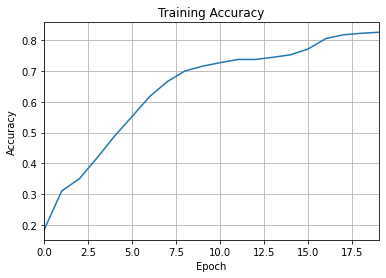

Test_accuracy 0.8639104220499569
Train with following parameters: out_channels: 88 kernel_size: 17  drop out: 0.5549933474249789 epochs: 20 batch_size: 48
Learn rate: 9.520263469255729e-06
Epoch: 1; Accuracy: 0.2905100064557779
Epoch: 2; Accuracy: 0.31332042177749087
Epoch: 3; Accuracy: 0.3888530234559931
Epoch: 4; Accuracy: 0.508284914998924
Epoch: 5; Accuracy: 0.548956315902733
Epoch: 6; Accuracy: 0.614159672907252
Epoch: 7; Accuracy: 0.689261889391005
Epoch: 8; Accuracy: 0.7295029051000645
Epoch: 9; Accuracy: 0.7508069722401549
Epoch: 10; Accuracy: 0.7813643210673553
Epoch: 11; Accuracy: 0.8003012696363245
Epoch: 12; Accuracy: 0.8063266623628147
Epoch: 13; Accuracy: 0.8106305143103077
Epoch: 14; Accuracy: 0.8151495588551754
Epoch: 15; Accuracy: 0.8170862922315473
Epoch: 16; Accuracy: 0.8235420701527868
Epoch: 17; Accuracy: 0.8256939961265333
Epoch: 18; Accuracy: 0.8282763072950291
Epoch: 19; Accuracy: 0.8334409296320207
Epoch: 20; Accuracy: 0.8347320852162685


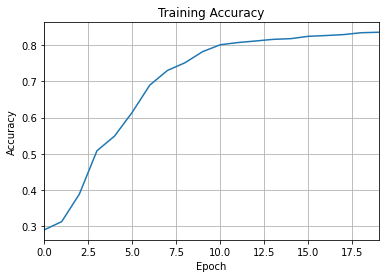

Test_accuracy 0.8320413436692506
Test_accuracy mean value 0.8153316106804478
the best parameters are:  {'out_channels': 96, 'd_out': 0.5940523525518683, 'k_size': 17, 'lr': 3.181356850253103e-05, 'num_epochs': 19, 'batch_size_tr': 72}
{'accuracy': 0.829256583085135}
{'accuracy': {'accuracy': 0.00010403218646134328}}


In [11]:
#Calling of the optimization function and definition of the parameters to be optimized for each model architecture
dtype = torch.float
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if lstm_flag==1:
  best_parameters, values, experiment, model = optimize(
      parameters=[
          {"name": "hiddenNode", "type": "range", "bounds": [256, 512]},
          {"name": "layer_num", "type": "range", "bounds": [1, 7]},
          {"name": "dropout", "type": "range", "bounds": [0.0, 0.5]},
          {"name": "lr", "type": "range", "bounds": [1e-6, 0.4], "log_scale": True},
          {"name": "num_epochs", "type": "range", "bounds": [5,20]}, 
          {"name": "batch_size_tr", "type": "range", "bounds": [16, 128]},       
      ],
      evaluation_function=aquisition_function,
      objective_name='accuracy',
  )
else:
  #perform optimization with accuracy as objective
  best_parameters, values, experiment, model = optimize(
      parameters=[
          {"name": "out_channels", "type": "range", "bounds": [8, 128]},
          {"name": "d_out", "type": "range", "bounds": [0.0, 1.0]},
          {"name": "k_size", "type": "range", "bounds": [1, 20]},
          {"name": "lr", "type": "range", "bounds": [1e-6, 0.4], "log_scale": True},
          {"name": "num_epochs", "type": "range", "bounds": [5,20]}, 
          {"name": "batch_size_tr", "type": "range", "bounds": [16, 128]},       
      ],
      evaluation_function=aquisition_function,
      objective_name='accuracy',
  )

print("the best parameters are: ",best_parameters)
means, covariances = values
print(means)
print(covariances)